## **DSC 180AB Data Science Capstone**
### Replication Project

**Team Members**:


*   Chester (Kai) Ni
*   Catherine Back
*   Yuancheng (Kaleo) Cao
*   Kavya Sriram



### Table of Contents
To return to the table of contents, click on the number at any major section heading.

[1. Introduction](#1.-Introduction)

[2. Exploratory Data Analysis](#2.-Exploratory-Data-Analysis)

[3. Model Development](#3.-Model-Development)

[4. Model Evaluation](#4.-Model-Evaluation)

[5. Bias Mitigation](#5.-Bias-Mitigation)

[6. Results Summary](#6.-Results-Summary)

[7. Explainability](#7.-Explainability)

[8. Conclusion & Discussion](#8.-Conclusion-&-Discussion)


## This tutorial demonstrates classification model learning with bias mitigation as a part of a Care Management use case using Medical Expenditure data.

The notebook demonstrates how the AIF 360 toolkit can be used to detect and reduce bias when learning classifiers using a variety of fairness metrics and algorithms. It also demonstrates how explanations can be generated for predictions made by models learnt with the toolkit using LIME.

* Classifiers are built using Logistic Regression as well as Random Forests.
* Bias detection is demonstrated using several metrics, including disparate impact, average odds difference, statistical parity difference, equal opportunity difference, and Theil index.
* Bias alleviation is explored via a variety of methods, including reweighing (pre-processing algorithm), prejudice remover (in-processing algorithm), and disparate impact remover (pre-processing technique).
* Data from the [Medical Expenditure Panel Survey](https://meps.ahrq.gov/mepsweb/) is used in this tutorial.


The Medical Expenditure Panel Survey (MEPS) provides nationally representative estimates of health expenditure, utilization, payment sources, health status, and health insurance coverage among the noninstitutionalized U.S. population. These government-produced data sets examine how people use the US healthcare system.

MEPS is administered by the Agency for Healthcare Research and Quality (AHRQ) and is divided into three components:
* Household
* Insurance/Employer, and
* Medical Provider.

These components provide comprehensive national estimates of health care use and payment by individuals, families, and any other demographic group of interest.

### [1.](#Table-of-Contents) Introduction

The [AI Fairness 360 toolkit](https://github.com/Trusted-AI/AIF360) is an extensible open-source library containing techniques developed by the research community to help detect and mitigate bias in machine learning models throughout the AI application lifecycle. AI Fairness 360 documentation is available [here](https://aif360.readthedocs.io/en/stable/).

The AI Fairness 360 package includes:
- a comprehensive set of metrics for datasets and models to test for biases,
- explanations for these metrics, and
- algorithms to mitigate bias in datasets and models
It is designed to translate algorithmic research from the lab into the actual practice of domains as wide-ranging as finance, human capital management, healthcare, and education

#### 1.1 Use Case

**In order to demonstrate how AIF360 can be used to detect and mitigate bias in classifier models, we adopt the following use case:**

* Data scientist develops a 'fair' healthcare utilization scoring model with respect to defined protected classes. Fairness may be dictated by legal or government regulations, such as a requirement that additional care decisions be not predicated on factors such as race of the patient.
* Developer takes the model AND performance characteristics / specs of the model (e.g. accuracy, fairness tests, etc. basically the model factsheet) and deploys the model in an enterprise app that prioritizes cases for care management.
* The app is put into production and starts scoring people and making recommendations.
* Explanations are generated for each recommendation
* Both recommendations and associated explanations are given to nurses as a part of the care management process. The nurses can evaluate the recommendations for quality and correctness and provide feedback.
* Nurse feedback as well as analysis of usage data with respect to specs of the model w.r.t accuracy and fairness is communicated to AI Ops specialist and LOB user periodically.
* When significant drift in model specs relative to the model factsheet is observed, the model is sent back for retraining.

#### 1.2 Data
Released as an ASCII file (with related SAS, SPSS, and STATA programming statements) and a SAS transport dataset, this public use file provides information collected on a nationally representative sample of the civilian noninstitutionalized population of the United States for calendar year 2015. This file consists of MEPS survey data obtained in Rounds 3, 4, and 5 of Panel 19 and Rounds 1, 2, and 3 of Panel 20 (i.e., the rounds for the MEPS panels covering calendar year 2015) and consolidates all of the final 2015 person-level variables onto one file. This file contains the following variables previously released on HC-174: survey administration, language of interview variable, demographics, parent identifiers, health status, disability days variables, access to care, employment, quality of care, patient satisfaction, health insurance, and use variables. The HC-181 file also includes these variables: income variables and expenditure variables.

The specific data used is the [2015 Full Year Consolidated Data File](https://meps.ahrq.gov/mepsweb/data_stats/download_data_files_detail.jsp?cboPufNumber=HC-181) as well as the [2016 Full Year Consolidated Data File](https://meps.ahrq.gov/mepsweb/data_stats/download_data_files_detail.jsp?cboPufNumber=HC-192).

* The 2015 file contains data from rounds 3,4,5 of panel 19 (2014) and rounds 1,2,3 of panel 20 (2015).
* The 2016 file contains data from rounds 3,4,5 of panel 20 (2015) and rounds 1,2,3 of panel 21 (2016).

In this example, three datasets were constructed: one from panel 19, round 5 (used for learning models), one from panel 20, round 3 (used for deployment/testing of model - steps); the other from panel 21, round 3 (used for re-training and deployment/testing of updated model).

#### 1.3 Methodology

For each dataset, the sensitive attribute is 'RACE' constructed as follows: 'Whites' (privileged class) defined by the features RACEV2X = 1 (White) and HISPANX = 2 (non Hispanic); 'Non-Whites' that included everyone else.  

* Along with race as the sensitive feature, other features used for modeling include demographics  (such as age, gender, active duty status), physical/mental health assessments, diagnosis codes (such as history of diagnosis of cancer, or diabetes), and limitations (such as cognitive or hearing or vision limitation).
* To measure utilization, a composite feature, 'UTILIZATION', was created to measure the total number of trips requiring some sort of medical care by summing up the following features: OBTOTV15(16), the number of office based visits;  OPTOTV15(16), the number of outpatient visits; ERTOT15(16), the number of ER visits;  IPNGTD15(16), the number of inpatient nights, and  + HHTOTD16, the number of home health visits.
* The model classification task is to predict whether a person would have 'high' utilization (defined as UTILIZATION >= 10, roughly the average utilization for the considered population). High utilization respondents constituted around 17% of each dataset.
* To simulate the scenario, each dataset is split into 3 parts: a train, a validation, and a test/deployment part.

**We assume that the model is initially built and tuned using the 2015 Panel 19 train/test data**
* It is then put into practice and used to score people to identify potential candidates for care management.
* Initial deployment is simulated to 2015 Panel 20 deployment data.
* To show change in performance and/or fairness over time, the 2016 Panel 21 deployment data is used.
* Finally, if drift is observed, the 2015 train/validation data is used to learn a new model and evaluated again on the 2016 deployment data

### 1.4 Insert writeup of overall replication project goals and big picture thinking (2-3 paragraphs).  
* **Why do we care about this?**
We care because this data can be used to explore trends and patterns in medicine and hospitals. It can help better our understanding in matters of health and relationships between diagnoses as well as provide more insight on overhead such as insurance coverage and hospital stays. If you factor in the different demographics in this data the information is very useful to the medical industry as it can enhance decision making in matters of health and administration.
* **What would the benefit of predicting utilization be?**
The benefit of predicting utilization could be improved decision making as well as more proactive behaviors rather than preventative which in the case of healthcare can be very essential. If you have an idea about who the diagnosis  of one disease can possibly be an indicator of another you can take preventative action and potentially improve the situation. Also it can shed light on other details regarding demographics and possible inequality of care which can also be combatted proactively.
* **What might occur if there are errors?**
Errors can be detrimental because in matters of health a wrong or missed diagnosis can be very serious. Also demographic mistakes can also be harmful as sometimes those can be key indicators to health issues along with other details. Also error in handling the data can lead to serious privacy violations which can also have major consequences.
* **Who are the affected parties and stakeholders?**
The affected parties and stakeholders are both patients and members of the healthcare industry, such as doctors. This is because the patient's health and data are at stake and can be affected by this exploration. Members of the healthcare industry are relevant because it is their job to properly utilize predictions and insights found to improve performance and experience for healthcare patients.
* **Other thoughts?**
The insights found from this data need to be very thoroughly checked as when it comes to health things aren’t very cut and dry. There are a lot of nuances and different meanings when it comes to health conditions and diagnoses that need to be considered before applying what is learned from the data.

---
End of Introduction

### [2.](#Table-of-Contents) Exploratory Data Analysis (EDA)


The specific data used is the [2015 Full Year Consolidated Data File](https://meps.ahrq.gov/mepsweb/data_stats/download_data_files_detail.jsp?cboPufNumber=HC-181) as well as the [2016 Full Year Consolidated Data File](https://meps.ahrq.gov/mepsweb/data_stats/download_data_files_detail.jsp?cboPufNumber=HC-192).

* The 2015 file contains data from rounds 3,4,5 of panel 19 (2014) and rounds 1,2,3 of panel 20 (2015).
* The 2016 file contains data from rounds 3,4,5 of panel 20 (2015) and rounds 1,2,3 of panel 21 (2016).

In this example, three datasets were constructed: one from panel 19, round 5 (used for learning models), one from panel 20, round 3 (used for deployment/testing of model - steps); the other from panel 21, round 3 (used for re-training and deployment/testing of updated model).

See the corresponding [Codebook](https://meps.ahrq.gov/mepsweb/data_stats/download_data_files_detail.jsp?cboPufNumber=HC-181) for information on variables.

##### Key MEPS dataset features include:
* **Utilization**: To measure utilization, a composite feature, 'UTILIZATION', was created to measure the total number of trips requiring some sort of medical care by summing up the following features: OBTOTV15(16), the number of office based visits;  OPTOTV15(16), the number of outpatient visits; ERTOT15(16), the number of ER visits;  IPNGTD15(16), the number of inpatient nights, and  + HHTOTD16, the number of home health visits.
* The model classification task is to predict whether a person would have **'high'** utilization (defined as UTILIZATION >= 10, roughly the average utilization for the considered population). High utilization respondents constituted around 17% of each dataset.

#### 2.0 Pre-processing Scripts (for each Panel)

There is currently minimal EDA for this tutorial within IBM AIF360 Medical Expenditure Tutorial. Therefore, we have adapted  utility scripts from IBM AIF360 Tutorial for ease of understanding for how datasets were pre-processed. These will be used primarily for EDA purposes. We will utilize IBM's tutorial for the remainder of the project. We have utilized Pandas for this portion of the project.

**Note:** these pre-processing script below are run for each data file, and then filtered for each panel. This was done in order to match subsequent portions of the tutorial, and how train/test/validation datasets were split.

#### 2.1 Get and Load Dataset, Apply Pre-processing

**Before Proceeding Ensure You Have:**
* Forked the AIF360 repository and cloned locally to your disk or virtual machine
* Downloaded the `h181.csv` and `h192.csv` data files uploaded [here](https://www.kaggle.com/datasets/nanrahman/mepsdata)
* Place the `h181.csv` and `h192.csv` in a folder you can access (we placed it in `../aif360/data/raw/meps/` of our forked AIF360 repository)
* For EDA we only focus on `h181.csv`

In [110]:
# !pip install aif360
# !pip install 'aif360[all]'

In [111]:
# Imports
import sys

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Markdown, display
import pandas as pd
import seaborn as sns

# Datasets
from aif360.datasets import MEPSDataset19
from aif360.datasets import MEPSDataset20
from aif360.datasets import MEPSDataset21
from aif360.datasets import StandardDataset

# Fairness metrics
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.metrics import ClassificationMetric

from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression

In [112]:
raw_181 = pd.read_csv('aif360/data/raw/meps/h181.csv')
raw_192 = pd.read_csv('aif360/data/raw/meps/h192.csv')

In [113]:
raw_181

,DUID,PID,DUPERSID,PANEL,FAMID31,FAMID42,FAMID53,FAMID15,FAMIDYR,CPSFAMID,...,RXOSR15,RXPTR15,RXOTH15,PERWT15F,FAMWT15F,FAMWT15C,SAQWT15F,DIABW15F,VARSTR,VARPSU
0,60001,101,60001101,19,A,A,A,A,A,A,...,0,0,0,21854.981705,22983.493815,22983.493815,23226.272970,26185.048789,1019,1
1,60001,102,60001102,19,A,A,A,A,A,B,...,0,0,4,18169.604822,22983.493815,14663.337957,20624.450027,22682.689497,1019,1
2,60001,103,60001103,19,A,A,A,A,A,B,...,0,0,0,23812.596388,22983.493815,14663.337957,31246.723516,0.000000,1019,1
3,60001,104,60001104,19,A,A,A,A,A,C,...,0,0,0,17191.832515,22983.493815,11200.744542,18125.280372,0.000000,1019,1
4,60001,105,60001105,19,A,A,A,A,A,C,...,0,0,265,20261.485463,22983.493815,11200.744542,0.000000,0.000000,1019,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35422,80569,108,80569108,20,B,A,D,D,A,A,...,0,0,0,2812.010290,2449.173357,2449.173357,0.000000,0.000000,1056,2
35423,80570,101,80570101,20,A,A,A,A,A,A,...,0,1248,0,11481.496934,13076.665735,13076.665735,11648.039744,0.000000,1126,1
35424,80571,101,80571101,20,A,A,A,A,A,A,...,0,0,0,8357.376060,7085.589291,7085.589291,9920.807391,0.000000,1144,1
35425,80571,102,80571102,20,A,A,A,A,A,A,...,0,1230,0,8389.102961,7085.589291,7085.589291,9141.136948,0.000000,1144,1


#### Apply pre-processing scripts

In [114]:
default_mappings = {
    'label_maps': [{1.0: '>= 10 Visits', 0.0: '< 10 Visits'}],
    'protected_attribute_maps': [{1.0: 'White', 0.0: 'Non-White'}]}

def default_preprocessing19(df):
    """
    1.Create a new column, RACE that is 'White' if RACEV2X = 1 and HISPANX = 2 i.e. non Hispanic White
      and 'non-White' otherwise
    2. Restrict to Panel 19
    3. RENAME all columns that are PANEL/ROUND SPECIFIC
    4. Drop rows based on certain values of individual features that correspond to missing/unknown - generally < -1
    5. Compute UTILIZATION, binarize it to 0 (< 10) and 1 (>= 10)
    """
    def race(row):
        if ((row['HISPANX'] == 2) and (row['RACEV2X'] == 1)):  #non-Hispanic Whites are marked as WHITE; all others as NON-WHITE
            return 'White'
        return 'Non-White'

    df['RACEV2X'] = df.apply(lambda row: race(row), axis=1)
    df = df.rename(columns = {'RACEV2X' : 'RACE'})

    df = df[df['PANEL'] == 19]

    # RENAME COLUMNS
    df = df.rename(columns = {'FTSTU53X' : 'FTSTU', 'ACTDTY53' : 'ACTDTY', 'HONRDC53' : 'HONRDC', 'RTHLTH53' : 'RTHLTH',
                              'MNHLTH53' : 'MNHLTH', 'CHBRON53' : 'CHBRON', 'JTPAIN53' : 'JTPAIN', 'PREGNT53' : 'PREGNT',
                              'WLKLIM53' : 'WLKLIM', 'ACTLIM53' : 'ACTLIM', 'SOCLIM53' : 'SOCLIM', 'COGLIM53' : 'COGLIM',
                              'EMPST53' : 'EMPST', 'REGION53' : 'REGION', 'MARRY53X' : 'MARRY', 'AGE53X' : 'AGE',
                              'POVCAT15' : 'POVCAT', 'INSCOV15' : 'INSCOV'})

    df = df[df['REGION'] >= 0] # remove values -1
    df = df[df['AGE'] >= 0] # remove values -1

    df = df[df['MARRY'] >= 0] # remove values -1, -7, -8, -9

    df = df[df['ASTHDX'] >= 0] # remove values -1, -7, -8, -9

    df = df[(df[['FTSTU','ACTDTY','HONRDC','RTHLTH','MNHLTH','HIBPDX','CHDDX','ANGIDX','EDUCYR','HIDEG',
                             'MIDX','OHRTDX','STRKDX','EMPHDX','CHBRON','CHOLDX','CANCERDX','DIABDX',
                             'JTPAIN','ARTHDX','ARTHTYPE','ASTHDX','ADHDADDX','PREGNT','WLKLIM',
                             'ACTLIM','SOCLIM','COGLIM','DFHEAR42','DFSEE42','ADSMOK42',
                             'PHQ242','EMPST','POVCAT','INSCOV']] >= -1).all(1)]  #for all other categorical features, remove values < -1

    def utilization(row):
        return row['OBTOTV15'] + row['OPTOTV15'] + row['ERTOT15'] + row['IPNGTD15'] + row['HHTOTD15']

    df['TOTEXP15'] = df.apply(lambda row: utilization(row), axis=1)
    lessE = df['TOTEXP15'] < 10.0
    df.loc[lessE,'TOTEXP15'] = 0.0
    moreE = df['TOTEXP15'] >= 10.0
    df.loc[moreE,'TOTEXP15'] = 1.0

    df = df.rename(columns = {'TOTEXP15' : 'UTILIZATION'})
    return df

In [115]:
def default_preprocessing20(df):
    """
    1.Create a new column, RACE that is 'White' if RACEV2X = 1 and HISPANX = 2 i.e. non Hispanic White
      and 'non-White' otherwise
    2. Restrict to Panel 20
    3. RENAME all columns that are PANEL/ROUND SPECIFIC
    4. Drop rows based on certain values of individual features that correspond to missing/unknown - generally < -1
    5. Compute UTILIZATION, binarize it to 0 (< 10) and 1 (>= 10)
    """
    def race(row):
        if ((row['HISPANX'] == 2) and (row['RACEV2X'] == 1)):  #non-Hispanic Whites are marked as WHITE; all others as NON-WHITE
            return 'White'
        return 'Non-White'

    df['RACEV2X'] = df.apply(lambda row: race(row), axis=1)
    df = df.rename(columns = {'RACEV2X' : 'RACE'})

    df = df[df['PANEL'] == 20]

    # RENAME COLUMNS
    df = df.rename(columns = {'FTSTU53X' : 'FTSTU', 'ACTDTY53' : 'ACTDTY', 'HONRDC53' : 'HONRDC', 'RTHLTH53' : 'RTHLTH',
                              'MNHLTH53' : 'MNHLTH', 'CHBRON53' : 'CHBRON', 'JTPAIN53' : 'JTPAIN', 'PREGNT53' : 'PREGNT',
                              'WLKLIM53' : 'WLKLIM', 'ACTLIM53' : 'ACTLIM', 'SOCLIM53' : 'SOCLIM', 'COGLIM53' : 'COGLIM',
                              'EMPST53' : 'EMPST', 'REGION53' : 'REGION', 'MARRY53X' : 'MARRY', 'AGE53X' : 'AGE',
                              'POVCAT15' : 'POVCAT', 'INSCOV15' : 'INSCOV'})

    df = df[df['REGION'] >= 0] # remove values -1
    df = df[df['AGE'] >= 0] # remove values -1

    df = df[df['MARRY'] >= 0] # remove values -1, -7, -8, -9

    df = df[df['ASTHDX'] >= 0] # remove values -1, -7, -8, -9

    df = df[(df[['FTSTU','ACTDTY','HONRDC','RTHLTH','MNHLTH','HIBPDX','CHDDX','ANGIDX','EDUCYR','HIDEG',
                             'MIDX','OHRTDX','STRKDX','EMPHDX','CHBRON','CHOLDX','CANCERDX','DIABDX',
                             'JTPAIN','ARTHDX','ARTHTYPE','ASTHDX','ADHDADDX','PREGNT','WLKLIM',
                             'ACTLIM','SOCLIM','COGLIM','DFHEAR42','DFSEE42','ADSMOK42',
                             'PHQ242','EMPST','POVCAT','INSCOV']] >= -1).all(1)]  #for all other categorical features, remove values < -1

    def utilization(row):
        return row['OBTOTV15'] + row['OPTOTV15'] + row['ERTOT15'] + row['IPNGTD15'] + row['HHTOTD15']

    df['TOTEXP15'] = df.apply(lambda row: utilization(row), axis=1)
    lessE = df['TOTEXP15'] < 10.0
    df.loc[lessE,'TOTEXP15'] = 0.0
    moreE = df['TOTEXP15'] >= 10.0
    df.loc[moreE,'TOTEXP15'] = 1.0

    df = df.rename(columns = {'TOTEXP15' : 'UTILIZATION'})
    return df

#### Taken from pre-processing scripts to retain same columns used in model development for tutorial

In [116]:
label_name='UTILIZATION'
favorable_classes=[1.0]
protected_attribute_names=['RACE']
privileged_classes=[['White']]
instance_weights_name='PERWT15F'
categorical_features=['REGION','SEX','MARRY',
                                 'FTSTU','ACTDTY','HONRDC','RTHLTH','MNHLTH','HIBPDX','CHDDX','ANGIDX',
                                 'MIDX','OHRTDX','STRKDX','EMPHDX','CHBRON','CHOLDX','CANCERDX','DIABDX',
                                 'JTPAIN','ARTHDX','ARTHTYPE','ASTHDX','ADHDADDX','PREGNT','WLKLIM',
                                 'ACTLIM','SOCLIM','COGLIM','DFHEAR42','DFSEE42', 'ADSMOK42', 'PHQ242',
                                 'EMPST','POVCAT','INSCOV']

features_to_keep=['REGION','AGE','SEX','RACE','MARRY',
                                 'FTSTU','ACTDTY','HONRDC','RTHLTH','MNHLTH','HIBPDX','CHDDX','ANGIDX',
                                 'MIDX','OHRTDX','STRKDX','EMPHDX','CHBRON','CHOLDX','CANCERDX','DIABDX',
                                 'JTPAIN','ARTHDX','ARTHTYPE','ASTHDX','ADHDADDX','PREGNT','WLKLIM',
                                 'ACTLIM','SOCLIM','COGLIM','DFHEAR42','DFSEE42', 'ADSMOK42',
                                 'PCS42','MCS42','K6SUM42','PHQ242','EMPST','POVCAT','INSCOV','UTILIZATION', 'PERWT15F']
features_to_drop=[]
na_values=[]
# custom_preprocessing=default_preprocessing <- don't need this yet for EDA
metadata=default_mappings


We encourage you to search through the repository and take a look at these scripts,
they can be found in `../aif360/dataset/` in your forked AIF360 repository:
* AIF360/aif360/datasets/meps_dataset_panel19_fy2015.py
* AIF360/aif360/datasets/meps_dataset_panel20_fy2015.py

To Explore the `Utilization` and `RACE` features, and the variables used to impute these features:
* See the corresponding [HC 181 Codebook](https://meps.ahrq.gov/mepsweb/data_stats/download_data_files_detail.jsp?cboPufNumber=HC-181) for information on variables.

In [117]:
df_panel_19 = default_preprocessing19(raw_181)
df_panel_19_reduced = df_panel_19[features_to_keep]

In [118]:
df_panel_20 = default_preprocessing20(raw_181)
df_panel_20_reduced = df_panel_20[features_to_keep]

**END OF PRE-PROCRESSING**


#### 2.2 Data shape and features

In [119]:
df_panel_19_reduced

,REGION,AGE,SEX,RACE,MARRY,FTSTU,ACTDTY,HONRDC,RTHLTH,MNHLTH,...,ADSMOK42,PCS42,MCS42,K6SUM42,PHQ242,EMPST,POVCAT,INSCOV,UTILIZATION,PERWT15F
0,2,53,1,White,5,-1,2,2,4,3,...,2,25.93,58.47,3,0,4,1,2,1,21854.981705
1,2,56,2,White,3,-1,2,2,4,3,...,2,20.42,26.57,17,6,4,3,2,1,18169.604822
3,2,23,2,White,5,3,2,2,1,1,...,2,53.12,50.33,7,0,1,2,2,0,17191.832515
4,2,3,1,White,6,-1,3,3,1,3,...,-1,-1.00,-1.00,-1,-1,-1,2,2,0,20261.485463
5,3,27,1,Non-White,1,-1,1,4,2,1,...,-1,-1.00,-1.00,-1,-1,1,3,1,0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16573,3,25,1,Non-White,1,-1,2,2,1,1,...,2,56.71,62.39,0,0,1,1,1,0,4111.315754
16574,3,25,2,Non-White,1,-1,2,2,1,1,...,2,56.71,62.39,0,0,4,1,1,0,5415.228173
16575,3,2,2,White,6,-1,3,3,1,1,...,-1,-1.00,-1.00,-1,-1,-1,1,2,0,3896.116219
16576,1,54,2,Non-White,3,-1,2,2,1,1,...,2,43.97,42.45,24,0,1,3,2,0,4883.851005


In [120]:
df_panel_20_reduced

,REGION,AGE,SEX,RACE,MARRY,FTSTU,ACTDTY,HONRDC,RTHLTH,MNHLTH,...,ADSMOK42,PCS42,MCS42,K6SUM42,PHQ242,EMPST,POVCAT,INSCOV,UTILIZATION,PERWT15F
16578,3,65,1,Non-White,1,-1,4,1,3,3,...,2,39.15,64.23,1,1,1,4,1,0,11966.862856
16579,3,57,2,Non-White,1,-1,2,2,3,3,...,2,23.61,48.28,5,3,4,4,1,1,10300.188631
16580,4,40,1,Non-White,1,-1,2,2,3,3,...,2,53.97,52.82,4,0,1,5,1,0,18749.279706
16581,3,55,2,Non-White,5,-1,2,2,3,3,...,1,40.50,61.61,0,0,1,2,2,0,5532.628347
16582,3,21,2,Non-White,5,1,2,2,3,3,...,-1,-1.00,-1.00,-1,-1,4,2,3,0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35422,3,8,1,Non-White,6,-1,3,3,1,1,...,-1,-1.00,-1.00,-1,-1,-1,1,2,0,2812.010290
35423,2,30,2,Non-White,5,-1,2,2,3,2,...,2,44.32,28.41,7,2,1,3,1,1,11481.496934
35424,3,32,1,Non-White,1,-1,2,2,3,2,...,2,36.80,61.23,1,0,1,5,1,0,8357.376060
35425,3,32,2,Non-White,1,-1,2,2,2,2,...,2,56.48,47.77,1,0,1,5,1,0,8389.102961


### **Data Overview and Feature Summary of `df_panel_19_reduced`**

In [121]:
# identify feature names (columns)
feature_names = df_panel_19_reduced.columns.tolist()
print("Feature Names: ", feature_names)

Feature Names:  ['REGION', 'AGE', 'SEX', 'RACE', 'MARRY', 'FTSTU', 'ACTDTY', 'HONRDC', 'RTHLTH', 'MNHLTH', 'HIBPDX', 'CHDDX', 'ANGIDX', 'MIDX', 'OHRTDX', 'STRKDX', 'EMPHDX', 'CHBRON', 'CHOLDX', 'CANCERDX', 'DIABDX', 'JTPAIN', 'ARTHDX', 'ARTHTYPE', 'ASTHDX', 'ADHDADDX', 'PREGNT', 'WLKLIM', 'ACTLIM', 'SOCLIM', 'COGLIM', 'DFHEAR42', 'DFSEE42', 'ADSMOK42', 'PCS42', 'MCS42', 'K6SUM42', 'PHQ242', 'EMPST', 'POVCAT', 'INSCOV', 'UTILIZATION', 'PERWT15F']


Feature Names | Definition/Explanation
--|--
REGION | Census region; 1:Northeast, 2:Midwest, 3:South, 4:West
FTSTU | Student status
ACTDTY | Active duty
HONRDC | Honorable discharge
RTHLTH | Perceived health status
MNHLTH | Perceived mental health status
HIBPDX | High blood pressure
CHDDX | Asked if ever diagnosed with coronary heart disease
ANGIDX | Asked if ever diagnosed with angina or angina pectoris
MIDX | Asked if ever diagnosed with heart attack or myocardial infraction
OHRTDX | Asked if ever diagnosed with any kind of heart disease or condition
STRKDX | Asked if ever diagnosed with a stroke or transient ischemic attack
EMPHDX | Asked if ever diagnosed with emphysema
CHBRON | Asked if had chronic bronchitis in last 12 months
CHOLDX | Asked if ever diagnosed with high cholesterol
CANCERDX | Asked if ever diagnosed with cancer or malignancy of any kind
DIABDX | Asked if ever diagnosed with diabetes
JTPAIN | Asked if had pain, swelling, or stiffness around a joint in last 12 months
ARTHDX | Asked if ever diagnosed with arthritis
ARTHTYPE | Arthritis Type; 1:Rheumatoid, 2: Osteoarthritis, 3:Non-specific
ASTHDX | Asked if ever diagnosed with asthma
ADHDADDX | Asked if ever diagnosed with ADHD or ADD
WLKLIM | Walking limitations
ACTLIM | Work, housework, and school limitations
SOCLIM | Social limitations
COGLIM | Cognitive limitations
DFHEAR42 | Difficulty hearing
DFSEE42 | Difficulty seeing
ADSMOK42 | Currently smokes
K6SUM42 | Kessler Index for non-specific, rather than disorder-specific, psychological distress: 0 None of the Time 1 A Little of the Time 2 Some of the Time 3 Most of the Time 4 All of the Time
PHQ242 | Summation of two variables: ADINTR42 – During the past two weeks, bothered by having little interest or pleasure in doing things, ADDPRS42 – During the past two weeks, bothered by feeling down, depressed, or hopeless
EMPST | Employment status
POVCAT | Poverty status
INSCOV | Health insurance coverage; 1:private, 2:public, 3:uninsured

In [122]:
# check for categorical features
categorical_features = df_panel_19_reduced.select_dtypes(include=['object', 'category']).columns.tolist()
print("Categorical Features: ", categorical_features)

Categorical Features:  ['RACE']


In [123]:
# summary statistics for numerical and catgeorical features
summary_stats = df_panel_19_reduced.describe(include='all')
print("Summary Statistics:\n", summary_stats)

Summary Statistics:
               REGION           AGE           SEX       RACE         MARRY  \
count   15830.000000  15830.000000  15830.000000      15830  15830.000000   
unique           NaN           NaN           NaN          2           NaN   
top              NaN           NaN           NaN  Non-White           NaN   
freq             NaN           NaN           NaN      10174           NaN   
mean        2.825584     35.090461      1.521162        NaN      3.661213   
std         1.002033     22.475549      0.499568        NaN      2.121255   
min         1.000000      0.000000      1.000000        NaN      1.000000   
25%         2.000000     15.000000      1.000000        NaN      1.000000   
50%         3.000000     33.000000      2.000000        NaN      5.000000   
75%         4.000000     53.000000      2.000000        NaN      6.000000   
max         4.000000     85.000000      2.000000        NaN     10.000000   

               FTSTU        ACTDTY        HONRDC      

In [124]:
# shape of the dataset
print("Shape of df_panel_19_reduced: ", df_panel_19_reduced.shape)

Shape of df_panel_19_reduced:  (15830, 43)


#### 2.3 Outlier Detection and Handling

In [125]:
#Handling Missing Values and Not Applicable Values

#Missing Values
missing_values = df_panel_19_reduced.isnull().sum()
print(missing_values[missing_values > 0]) #There are no columns that have missing values

# Not Applicable Values
df_panel_19_numeric = df_panel_19_reduced.apply(pd.to_numeric, errors='coerce')

# Now check for values less than or equal to 0
check_na = df_panel_19_numeric < 0

# Count how many such values exist in each column
na_count = check_na.sum()

# Display columns that have any negative values or zero
# print(na_count[na_count > 0])

df_panel_19_numeric[df_panel_19_numeric < 0] = -1

# Display columns that have any negative values or zero
print(na_count[na_count > 0])


Series([], dtype: int64)
FTSTU       14316
RTHLTH         18
MNHLTH         18
HIBPDX       4474
CHDDX        4474
ANGIDX       4474
MIDX         4474
OHRTDX       4474
STRKDX       4474
EMPHDX       4474
CHBRON       4490
CHOLDX       4474
CANCERDX     4474
DIABDX       4474
JTPAIN       4490
ARTHDX       4474
ARTHTYPE    12893
ADHDADDX    12022
PREGNT      12568
WLKLIM         18
ACTLIM       1086
SOCLIM         18
COGLIM       4490
DFHEAR42      357
DFSEE42       357
ADSMOK42     6235
PCS42        6286
MCS42        6280
K6SUM42      6410
PHQ242       6235
EMPST        3976
dtype: int64


In [126]:
# Applying One Hot Encoding and ignores columns that are numerical
df_panel_19_onehot = pd.get_dummies(df_panel_19_numeric, dtype=int, columns=[col for col in df_panel_19_numeric.columns if not col in ['AGE', 'PCS42','MCS42', 'PHQ242', 'PERWT15F', 'UTILIZATION']])
df_panel_19_onehot

,AGE,PCS42,MCS42,PHQ242,UTILIZATION,PERWT15F,REGION_1,REGION_2,REGION_3,REGION_4,...,EMPST_3,EMPST_4,POVCAT_1,POVCAT_2,POVCAT_3,POVCAT_4,POVCAT_5,INSCOV_1,INSCOV_2,INSCOV_3
0,53,25.93,58.47,0,1,21854.981705,0,1,0,0,...,0,1,1,0,0,0,0,0,1,0
1,56,20.42,26.57,6,1,18169.604822,0,1,0,0,...,0,1,0,0,1,0,0,0,1,0
3,23,53.12,50.33,0,0,17191.832515,0,1,0,0,...,0,0,0,1,0,0,0,0,1,0
4,3,-1.00,-1.00,-1,0,20261.485463,0,1,0,0,...,0,0,0,1,0,0,0,0,1,0
5,27,-1.00,-1.00,-1,0,0.000000,0,0,1,0,...,0,0,0,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16573,25,56.71,62.39,0,0,4111.315754,0,0,1,0,...,0,0,1,0,0,0,0,1,0,0
16574,25,56.71,62.39,0,0,5415.228173,0,0,1,0,...,0,1,1,0,0,0,0,1,0,0
16575,2,-1.00,-1.00,-1,0,3896.116219,0,0,1,0,...,0,0,1,0,0,0,0,0,1,0
16576,54,43.97,42.45,0,0,4883.851005,1,0,0,0,...,0,0,0,0,1,0,0,0,1,0


#### 2.4 Correlation Analysis

<Figure size 3000x2500 with 0 Axes>

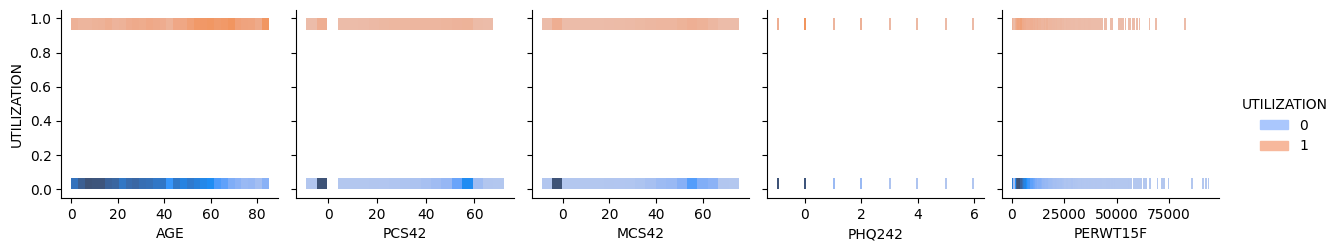

In [127]:
# Preliminary data visualizations

# Pairplot
plt.figure(figsize=(30,25))
sns.pairplot(df_panel_19_reduced,
             y_vars=['UTILIZATION'],
             x_vars=['AGE', 'PCS42','MCS42', 'PHQ242', 'PERWT15F'],
             kind="hist",
             hue="UTILIZATION",
             palette="coolwarm")

plt.show()

Here we take a look at five numeric features -- AGE, PCS42, MCS42, PHQ242, PERWT15F -- and map their histograms with UTILIZATION. Darker hues indicate a higher concentration of values, where lighter hues indicate a lower concentration. Values 0 and 1, depicted as blue and orange, represent individuals who were marked as low and high utilization respectively. From these visualizations, some clear trends are visible. For instance, individuals with low utilization tend to be younger, clustering between 0-50, whereas individuals with high utilization tend to be older, clustering around 60. This intuitively makes sense, given that older people are generally more likely to need more medical and health attention, resulting in higher utilization. In contrast, not as much can be determined from the visualization for PHQ242, a feature that tracks mental wellbeing with higher values being worse. It appears that most individuals have a value of 0, indicating no symptoms of depression, or -1, indicating inapplicable for this metric.

In [128]:
corr = df_panel_19_onehot.select_dtypes(include='number').corr()
corr['UTILIZATION'].sort_values(ascending=False)


UTILIZATION    1.000000
WLKLIM_1       0.370146
ARTHDX_1       0.362279
ACTLIM_1       0.353689
AGE            0.337893
                 ...   
ADSMOK42_-1   -0.207257
ACTLIM_2      -0.217069
SOCLIM_2      -0.275891
ARTHTYPE_-1   -0.362279
WLKLIM_2      -0.371547
Name: UTILIZATION, Length: 157, dtype: float64

In [129]:
top_25 = corr['UTILIZATION'].sort_values(ascending=False).head(25)
top_25

UTILIZATION    1.000000
WLKLIM_1       0.370146
ARTHDX_1       0.362279
ACTLIM_1       0.353689
AGE            0.337893
JTPAIN_1       0.326043
ACTDTY_4       0.315706
HIBPDX_1       0.285190
CHOLDX_1       0.276956
SOCLIM_1       0.274435
EMPST_4        0.273303
PHQ242         0.265856
CANCERDX_1     0.258458
ARTHTYPE_2     0.248862
COGLIM_1       0.242918
OHRTDX_1       0.236768
DIABDX_1       0.215140
CHDDX_1        0.213176
ARTHTYPE_3     0.208478
RTHLTH_4       0.199797
ADSMOK42_2     0.184743
MARRY_2        0.171158
STRKDX_1       0.169424
RTHLTH_5       0.169202
ADHDADDX_-1    0.165711
Name: UTILIZATION, dtype: float64

In [130]:
bottom_25 = corr['UTILIZATION'].sort_values(ascending=True).head(25)
bottom_25

WLKLIM_2      -0.371547
ARTHTYPE_-1   -0.362279
SOCLIM_2      -0.275891
ACTLIM_2      -0.217069
ADSMOK42_-1   -0.207257
K6SUM42_-1    -0.194712
CANCERDX_-1   -0.183844
EMPHDX_-1     -0.183844
MIDX_-1       -0.183844
ANGIDX_-1     -0.183844
CHOLDX_-1     -0.183844
OHRTDX_-1     -0.183844
DIABDX_-1     -0.183844
CHDDX_-1      -0.183844
ARTHDX_-1     -0.183844
HIBPDX_-1     -0.183844
STRKDX_-1     -0.183844
RTHLTH_1      -0.181325
JTPAIN_-1     -0.181322
CHBRON_-1     -0.181322
COGLIM_-1     -0.181322
HONRDC_3      -0.179990
ADHDADDX_2    -0.178414
ACTDTY_3      -0.176390
EMPST_-1      -0.176390
Name: UTILIZATION, dtype: float64

In [131]:
corr_series = corr.unstack()
corr_series = corr_series[corr_series.index.get_level_values(0) != corr_series.index.get_level_values(1)]
corr_series = corr_series.drop_duplicates()

top_10_corr = corr_series.nlargest(20)
bottom_10_corr = corr_series.nsmallest(20)

top_10_df = pd.DataFrame({
    'col1': top_10_corr.index.get_level_values(0),
    'col2': top_10_corr.index.get_level_values(1),
    'corr': top_10_corr.values
})

bottom_10_df = pd.DataFrame({
    'col1': bottom_10_corr.index.get_level_values(0),
    'col2': bottom_10_corr.index.get_level_values(1),
    'corr': bottom_10_corr.values
})

print(top_10_df)

print(bottom_10_df)

           col1        col2      corr
0       MARRY_6    ACTDTY_3  1.000000
1     HIBPDX_-1   CHBRON_-1  0.997513
2     CHBRON_-1   CHOLDX_-1  0.997513
3   ADSMOK42_-1  K6SUM42_-1  0.977220
4      HONRDC_3   HIBPDX_-1  0.961137
5       MARRY_6    HONRDC_3  0.959997
6      HONRDC_3    EMPST_-1  0.959997
7      HONRDC_3   CHBRON_-1  0.958747
8      EMPHDX_2    CHBRON_2  0.952128
9      ANGIDX_2      MIDX_2  0.937940
10     ANGIDX_2    EMPHDX_2  0.937930
11     ANGIDX_2    CHBRON_2  0.937628
12      CHDDX_2      MIDX_2  0.936434
13        PCS42       MCS42  0.924988
14      MARRY_6   HIBPDX_-1  0.922689
15    HIBPDX_-1    EMPST_-1  0.922689
16      CHDDX_2    ANGIDX_2  0.921900
17       MIDX_2    CHBRON_2  0.921867
18       MIDX_2    EMPHDX_2  0.921867
19      MARRY_6   CHBRON_-1  0.920395
         col1         col2      corr
0    ARTHDX_1  ARTHTYPE_-1 -1.000000
1    ASTHDX_1     ASTHDX_2 -1.000000
2       SEX_1        SEX_2 -1.000000
3    WLKLIM_1     WLKLIM_2 -0.993506
4    SOCLIM_1    

#### 2.5 Other analysis

### Insurance Coverage and Insurance Utilization
We wanted to see the breakdown distribution of the insurance coverage levels and utilization. The reason for this is that different insurance coverage might influence the amount of utilization a person would have. After analyzing the heatmap, it is clear that there is more data with low insurance utilization overall. Those with high utilization and no health insurance are disproportionately lower compared to other sections. 

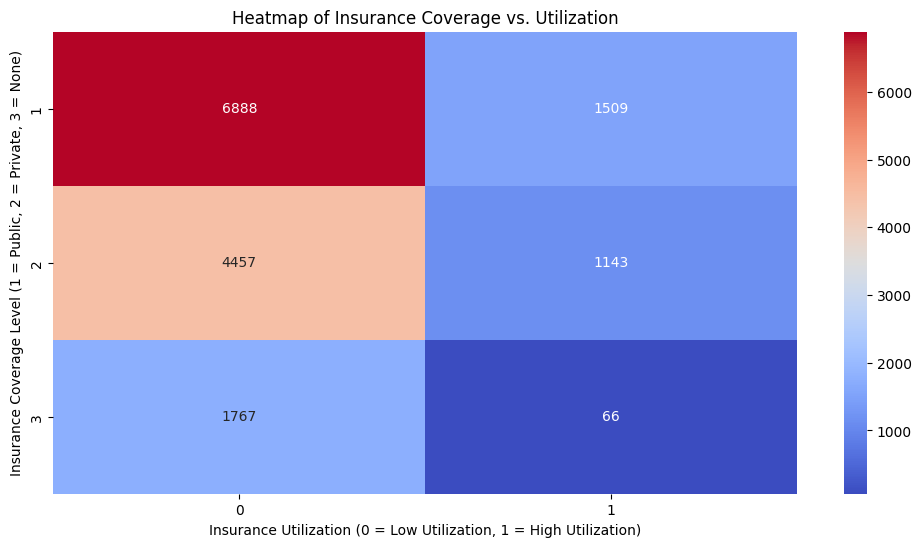

In [132]:
#Heat Map for Insurance Coverage and Insurance Utilization
heatmap_data = df_panel_19_reduced.pivot_table(index='INSCOV', columns='UTILIZATION', aggfunc='size', fill_value=0)
plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data, annot=True, fmt='d', cmap='coolwarm')
plt.title('Heatmap of Insurance Coverage vs. Utilization')
plt.xlabel('Insurance Utilization (0 = Low Utilization, 1 = High Utilization)')
plt.ylabel('Insurance Coverage Level (1 = Public, 2 = Private, 3 = None)')
plt.show()

### Box Plot of Age by Utilization
We wanted to see the breakdown of Utilization by age within the dataset. The reason for this is that it is expected for the utilization to increase as age increase, so we wanted to confirm that this trend is seen in this dataset. As expected we see that the average age for low utilization is around 30, while the average age for high utilization is late 50's.

/var/folders/fy/20h6tjtj0lb6vgm0w4qt4m2c0000gn/T/ipykernel_32257/2064754873.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='UTILIZATION', y='AGE', data=df_panel_19_reduced, palette='coolwarm')


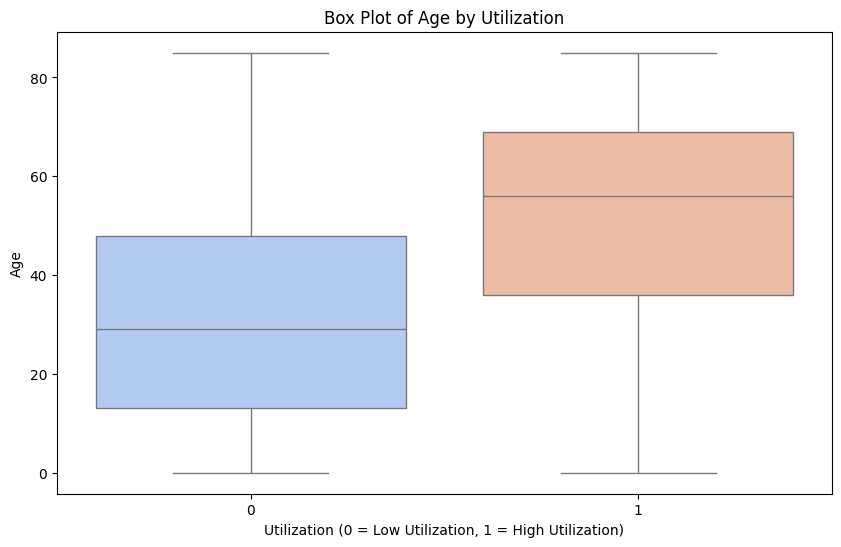

In [133]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='UTILIZATION', y='AGE', data=df_panel_19_reduced, palette='coolwarm')
plt.title('Box Plot of Age by Utilization')
plt.xlabel('Utilization (0 = Low Utilization, 1 = High Utilization)')
plt.ylabel('Age')
plt.show()

### Utilization by Census Region
This chart shows the count of hospital utilization cases by census region, divided into low and high utilization levels. The South region has the highest total count, with a larger portion of high utilization cases compared to other regions.

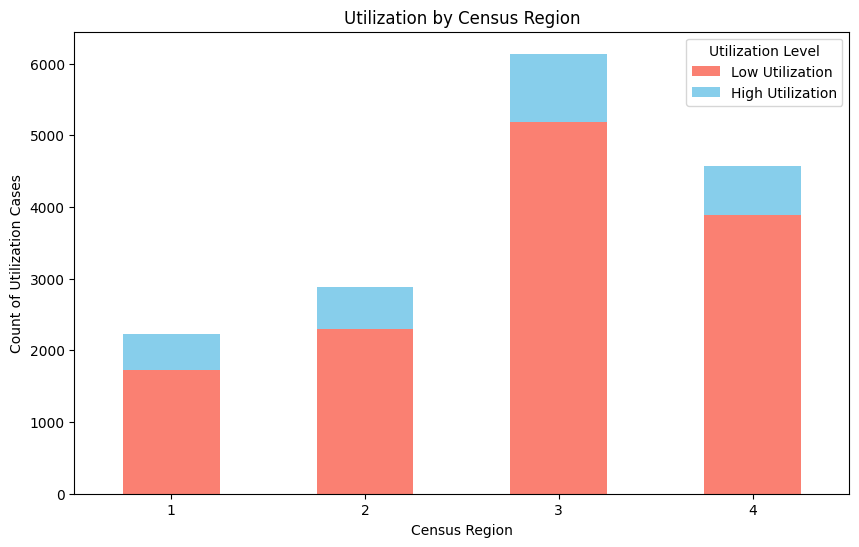

In [134]:
counts = df_panel_19_reduced.groupby(['REGION', 'UTILIZATION']).size().unstack(fill_value=0)

plot = counts.plot(kind='bar', stacked=True, color=['salmon', 'skyblue'], figsize=(10, 6))
plt.title('Utilization by Census Region')
plt.xlabel('Census Region')
plt.ylabel('Count of Utilization Cases')
plt.legend(title='Utilization Level', labels=['Low Utilization', 'High Utilization'])
plt.xticks(rotation=0)
plt.show()

### Pie Charts of Utilization Distribution by Income Level:
Poor/Negative: 84.8% of cases are low utilization, and 15.2% are high utilization.
Near Poor: 83.3% low utilization, 16.7% high utilization.
Low Income: 83.7% low utilization, 16.3% high utilization.
Middle Income: 84.9% low utilization, 15.1% high utilization.
High Income: Shows a lower percentage of low utilization (78.2%) and a higher proportion of high utilization (21.8%) than other income groups.
These pie charts provide a comparison of utilization levels across different income groups, highlighting a trend of increased high utilization in higher income levels. 


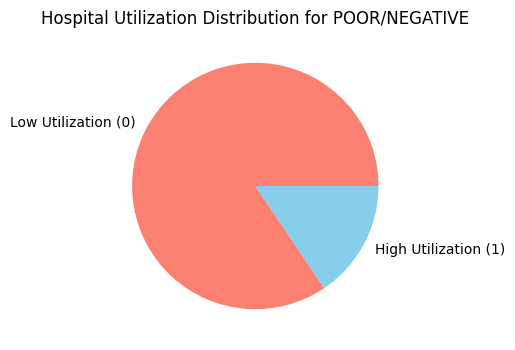

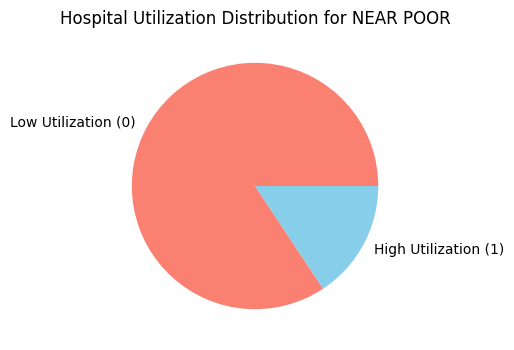

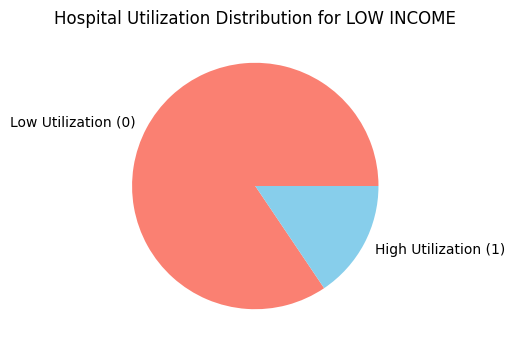

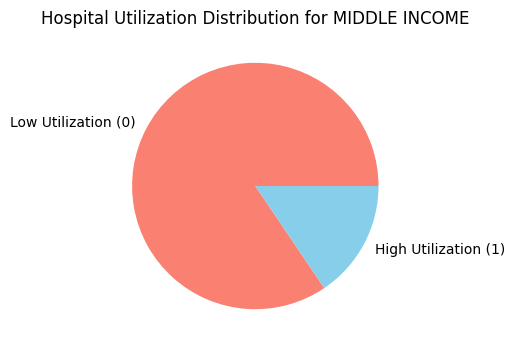

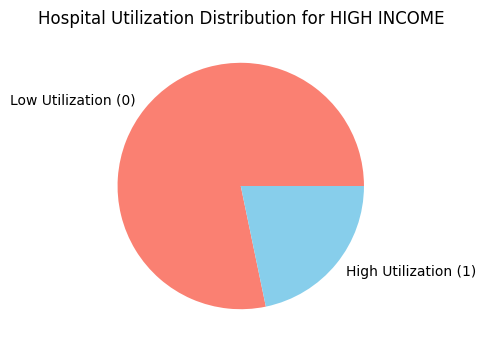

In [135]:
counts = df_panel_19_reduced.groupby(['POVCAT', 'UTILIZATION']).size().unstack(fill_value=0)

poverty_map = {
    1: 'POOR/NEGATIVE',
    2: 'NEAR POOR',
    3: 'LOW INCOME',
    4: 'MIDDLE INCOME',
    5: 'HIGH INCOME'
}

for poverty in counts.index:
    plt.figure(figsize=(4, 4))
    plt.pie(counts.loc[poverty], 
            labels=['Low Utilization (0)', 'High Utilization (1)'], 
            colors=['salmon', 'skyblue'])
    plt.title(f'Hospital Utilization Distribution for {poverty_map[poverty]}')
    plt.show()

Below bar chart shows the count of individuals with low and high utiization based on sex (1=Male, 2=Female). The red section represents low utilization, while the blue section represents high utilization. Both sexes have more individuals in the low utilization category compared to the high utilization category. The total count of males and females appears similar, with females showing slightly more individuals in the high utilization category compared to males.

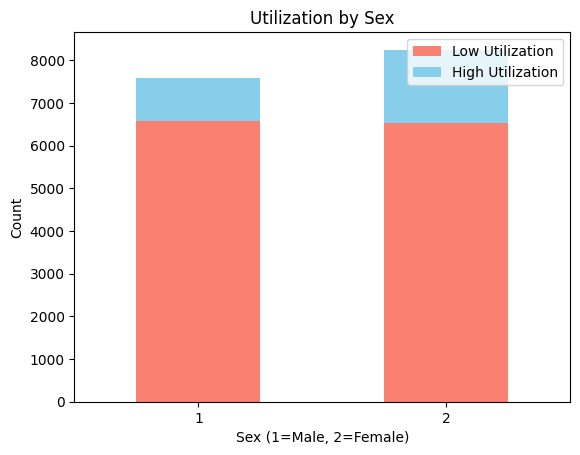

In [136]:
grouped_data = df_panel_19_reduced.groupby(['SEX', 'UTILIZATION']).size().unstack().fillna(0)

fig, ax = plt.subplots()
grouped_data.plot(kind='bar', stacked=True, ax=ax, color=['salmon', 'skyblue'])
ax.set_title("Utilization by Sex")
ax.set_xlabel("Sex (1=Male, 2=Female)")
ax.set_ylabel("Count")
ax.legend(["Low Utilization", "High Utilization"])
plt.xticks(rotation=0)
plt.show()

**Analyzing the Relationship Between Health Status and Healthcare Utilization**

The visualization below shows the count of individuals by the mean of the sum of their perceived health status and mental health status (1 = Best, 5 = Worst) and their utilization level. Most individuals fall into health statuses closer to 1 (better health), with fewer individuals as health status worsens (higher numbers). Low utilization is higher in all health status groups, but high utilization increases as health status worsens. The counts are highest at a health status of 1, with a gradual decrease toward 5.

/var/folders/fy/20h6tjtj0lb6vgm0w4qt4m2c0000gn/T/ipykernel_32257/599489003.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_panel_19_reduced['HEALTH_MEAN'] = (df_panel_19_reduced['MNHLTH'] + df_panel_19_reduced['RTHLTH']) / 2


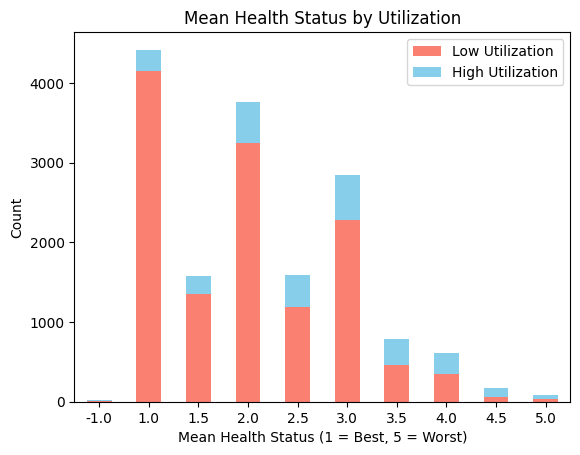

In [137]:
df_panel_19_reduced['HEALTH_MEAN'] = (df_panel_19_reduced['MNHLTH'] + df_panel_19_reduced['RTHLTH']) / 2

grouped_health_utilization = df_panel_19_reduced.groupby(['HEALTH_MEAN', 'UTILIZATION']).size().unstack().fillna(0)

fig, ax = plt.subplots()
grouped_health_utilization.plot(kind='bar', stacked=True, ax=ax, color=['salmon', 'skyblue'])
ax.set_title("Mean Health Status by Utilization")
ax.set_xlabel("Mean Health Status (1 = Best, 5 = Worst)")
ax.set_ylabel("Count")
ax.legend(["Low Utilization", "High Utilization"])
plt.xticks(rotation=0)
plt.show()

-----
End of Exploratory Data Analysis

### [3.](#Table-of-Contents) Model Development without Debiasing

First, load all necessary packages

In [138]:
import sys
sys.path.insert(0, '../')

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Markdown, display

# Datasets
from aif360.datasets import MEPSDataset19
from aif360.datasets import MEPSDataset20
from aif360.datasets import MEPSDataset21

# Fairness metrics
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.metrics import ClassificationMetric

# Explainers
from aif360.explainers import MetricTextExplainer

# Scalers
from sklearn.preprocessing import StandardScaler

# Classifiers
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

# Bias mitigation techniques
from aif360.algorithms.preprocessing import Reweighing
from aif360.algorithms.inprocessing import PrejudiceRemover

# LIME
# from aif360.datasets.lime_encoder import LimeEncoder
# import lime
# from lime.lime_tabular import LimeTabularExplainer

np.random.seed(1)

### 3.1. Load data & create splits for learning/validating/testing model

Get the dataset and split into train (50%), validate (30%), and test (20%)

In [139]:
(dataset_orig_panel19_train,
 dataset_orig_panel19_val,
 dataset_orig_panel19_test) = MEPSDataset19().split([0.5, 0.8], shuffle=True)

sens_ind = 0
sens_attr = dataset_orig_panel19_train.protected_attribute_names[sens_ind]

unprivileged_groups = [{sens_attr: v} for v in
                       dataset_orig_panel19_train.unprivileged_protected_attributes[sens_ind]]
privileged_groups = [{sens_attr: v} for v in
                     dataset_orig_panel19_train.privileged_protected_attributes[sens_ind]]

This function will be used throughout the notebook to print out some labels, names, etc.

In [140]:
def describe(train=None, val=None, test=None):
    if train is not None:
        display(Markdown("#### Training Dataset shape"))
        print(train.features.shape)
    if val is not None:
        display(Markdown("#### Validation Dataset shape"))
        print(val.features.shape)
    display(Markdown("#### Test Dataset shape"))
    print(test.features.shape)
    display(Markdown("#### Favorable and unfavorable labels"))
    print(test.favorable_label, test.unfavorable_label)
    display(Markdown("#### Protected attribute names"))
    print(test.protected_attribute_names)
    display(Markdown("#### Privileged and unprivileged protected attribute values"))
    print(test.privileged_protected_attributes, 
          test.unprivileged_protected_attributes)
    display(Markdown("#### Dataset feature names"))
    print(test.feature_names)

Show 2015 dataset details

In [141]:
describe(dataset_orig_panel19_train, dataset_orig_panel19_val, dataset_orig_panel19_test)

#### Training Dataset shape

(7915, 138)


#### Validation Dataset shape

(4749, 138)


#### Test Dataset shape

(3166, 138)


#### Favorable and unfavorable labels

1.0 0.0


#### Protected attribute names

['RACE']


#### Privileged and unprivileged protected attribute values

[array([1.])] [array([0.])]


#### Dataset feature names

['AGE', 'RACE', 'PCS42', 'MCS42', 'K6SUM42', 'REGION=1', 'REGION=2', 'REGION=3', 'REGION=4', 'SEX=1', 'SEX=2', 'MARRY=1', 'MARRY=2', 'MARRY=3', 'MARRY=4', 'MARRY=5', 'MARRY=6', 'MARRY=7', 'MARRY=8', 'MARRY=9', 'MARRY=10', 'FTSTU=-1', 'FTSTU=1', 'FTSTU=2', 'FTSTU=3', 'ACTDTY=1', 'ACTDTY=2', 'ACTDTY=3', 'ACTDTY=4', 'HONRDC=1', 'HONRDC=2', 'HONRDC=3', 'HONRDC=4', 'RTHLTH=-1', 'RTHLTH=1', 'RTHLTH=2', 'RTHLTH=3', 'RTHLTH=4', 'RTHLTH=5', 'MNHLTH=-1', 'MNHLTH=1', 'MNHLTH=2', 'MNHLTH=3', 'MNHLTH=4', 'MNHLTH=5', 'HIBPDX=-1', 'HIBPDX=1', 'HIBPDX=2', 'CHDDX=-1', 'CHDDX=1', 'CHDDX=2', 'ANGIDX=-1', 'ANGIDX=1', 'ANGIDX=2', 'MIDX=-1', 'MIDX=1', 'MIDX=2', 'OHRTDX=-1', 'OHRTDX=1', 'OHRTDX=2', 'STRKDX=-1', 'STRKDX=1', 'STRKDX=2', 'EMPHDX=-1', 'EMPHDX=1', 'EMPHDX=2', 'CHBRON=-1', 'CHBRON=1', 'CHBRON=2', 'CHOLDX=-1', 'CHOLDX=1', 'CHOLDX=2', 'CANCERDX=-1', 'CANCERDX=1', 'CANCERDX=2', 'DIABDX=-1', 'DIABDX=1', 'DIABDX=2', 'JTPAIN=-1', 'JTPAIN=1', 'JTPAIN=2', 'ARTHDX=-1', 'ARTHDX=1', 'ARTHDX=2', 'ARTHTYPE=-1'

Metrics for original data

In [142]:
metric_orig_panel19_train = BinaryLabelDatasetMetric(
        dataset_orig_panel19_train,
        unprivileged_groups=unprivileged_groups,
        privileged_groups=privileged_groups)
explainer_orig_panel19_train = MetricTextExplainer(metric_orig_panel19_train)

print(explainer_orig_panel19_train.disparate_impact())

Disparate impact (probability of favorable outcome for unprivileged instances / probability of favorable outcome for privileged instances): 0.482305229962759


#### 3.2. Learning a Logistic Regression (LR) classifier on original data

##### 3.2.1. Training LR model on original data

In [143]:
dataset = dataset_orig_panel19_train
model = make_pipeline(StandardScaler(),
                      LogisticRegression(solver='liblinear', random_state=1))
fit_params = {'logisticregression__sample_weight': dataset.instance_weights}

lr_orig_panel19 = model.fit(dataset.features, dataset.labels.ravel(), **fit_params)

##### 3.2.2. Validating LR model on original data

This function will be used throughout the tutorial to find best threshold using a validation set

In [144]:
from collections import defaultdict

def test(dataset, model, thresh_arr):
    try:
        # sklearn classifier
        y_val_pred_prob = model.predict_proba(dataset.features)
        pos_ind = np.where(model.classes_ == dataset.favorable_label)[0][0]
    except AttributeError:
        # aif360 inprocessing algorithm
        y_val_pred_prob = model.predict(dataset).scores
        pos_ind = 0
    
    metric_arrs = defaultdict(list)
    for thresh in thresh_arr:
        y_val_pred = (y_val_pred_prob[:, pos_ind] > thresh).astype(np.float64)

        dataset_pred = dataset.copy()
        dataset_pred.labels = y_val_pred
        metric = ClassificationMetric(
                dataset, dataset_pred,
                unprivileged_groups=unprivileged_groups,
                privileged_groups=privileged_groups)

        metric_arrs['bal_acc'].append((metric.true_positive_rate()
                                     + metric.true_negative_rate()) / 2)
        metric_arrs['avg_odds_diff'].append(metric.average_odds_difference())
        metric_arrs['disp_imp'].append(metric.disparate_impact())
        metric_arrs['stat_par_diff'].append(metric.statistical_parity_difference())
        metric_arrs['eq_opp_diff'].append(metric.equal_opportunity_difference())
        metric_arrs['theil_ind'].append(metric.theil_index())
    
    return metric_arrs

In [145]:
thresh_arr = np.linspace(0.01, 0.5, 50)
val_metrics = test(dataset=dataset_orig_panel19_val,
                   model=lr_orig_panel19,
                   thresh_arr=thresh_arr)
lr_orig_best_ind = np.argmax(val_metrics['bal_acc'])

Plot metrics with twin x-axes

In [146]:
def plot(x, x_name, y_left, y_left_name, y_right, y_right_name):
    fig, ax1 = plt.subplots(figsize=(10,7))
    ax1.plot(x, y_left)
    ax1.set_xlabel(x_name, fontsize=16, fontweight='bold')
    ax1.set_ylabel(y_left_name, color='b', fontsize=16, fontweight='bold')
    ax1.xaxis.set_tick_params(labelsize=14)
    ax1.yaxis.set_tick_params(labelsize=14)
    ax1.set_ylim(0.5, 0.8)

    ax2 = ax1.twinx()
    ax2.plot(x, y_right, color='r')
    ax2.set_ylabel(y_right_name, color='r', fontsize=16, fontweight='bold')
    if 'DI' in y_right_name:
        ax2.set_ylim(0., 0.7)
    else:
        ax2.set_ylim(-0.25, 0.1)

    best_ind = np.argmax(y_left)
    ax2.axvline(np.array(x)[best_ind], color='k', linestyle=':')
    ax2.yaxis.set_tick_params(labelsize=14)
    ax2.grid(True)

Here we plot $1 - \min(\text{disparate impact}, 1/\text{disparate impact})$ since it's possible to overcorrect and end up with a value greater than 1, implying unfairness for the original privileged group. For shorthand, we simply call this 1-min(DI, 1/DI) from now on. We want the plotted metric to be less than 0.2.

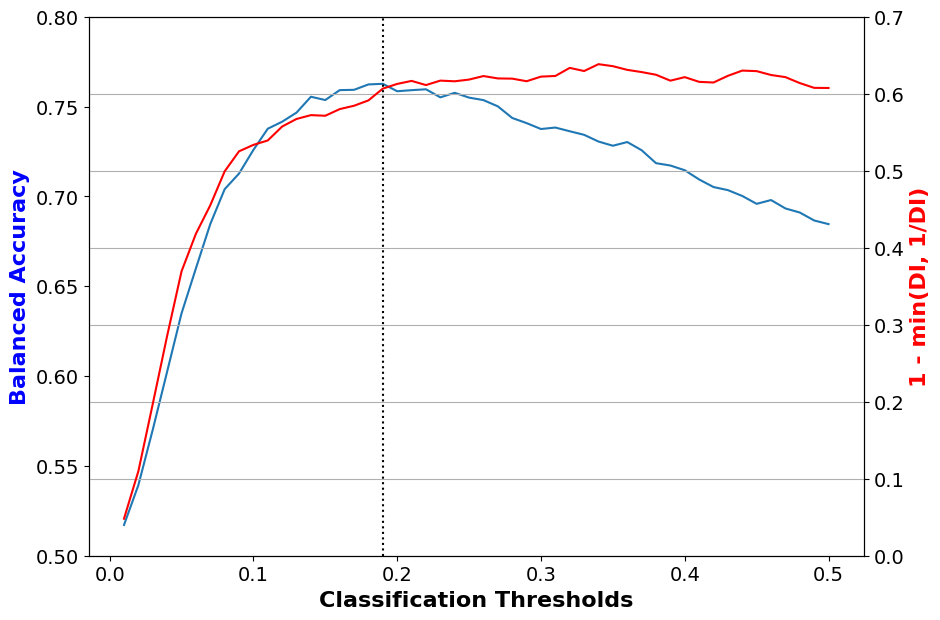

In [147]:
disp_imp = np.array(val_metrics['disp_imp'])
disp_imp_err = 1 - np.minimum(disp_imp, 1/disp_imp)
plot(thresh_arr, 'Classification Thresholds',
     val_metrics['bal_acc'], 'Balanced Accuracy',
     disp_imp_err, '1 - min(DI, 1/DI)')

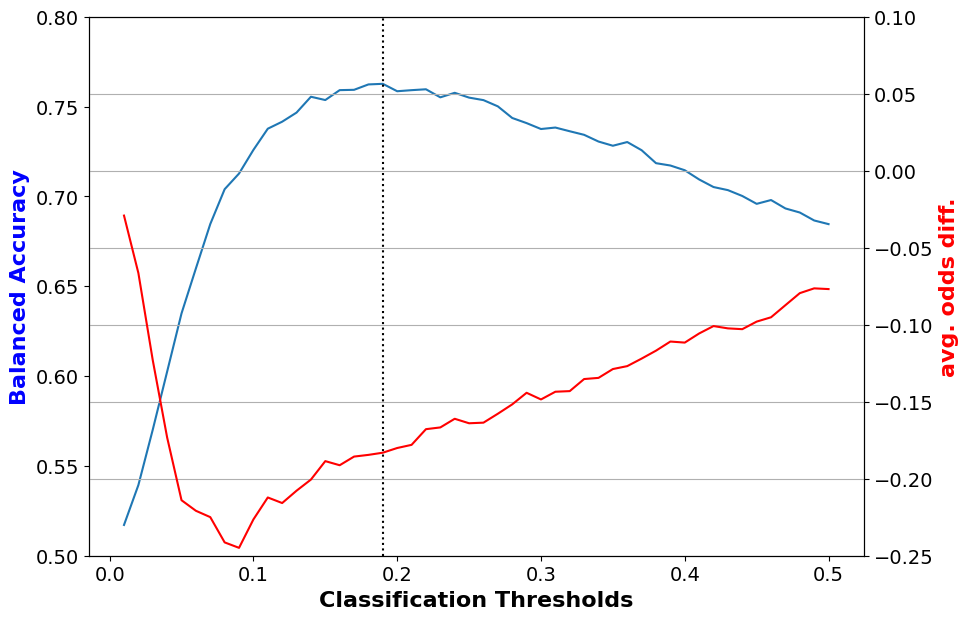

In [148]:
plot(thresh_arr, 'Classification Thresholds',
     val_metrics['bal_acc'], 'Balanced Accuracy',
     val_metrics['avg_odds_diff'], 'avg. odds diff.')

Make a function to print out accuracy and fairness metrics. This will be used throughout the tutorial.

In [149]:
def describe_metrics(metrics, thresh_arr):
    best_ind = np.argmax(metrics['bal_acc'])
    print("Threshold corresponding to Best balanced accuracy: {:6.4f}".format(thresh_arr[best_ind]))
    print("Best balanced accuracy: {:6.4f}".format(metrics['bal_acc'][best_ind]))
#     disp_imp_at_best_ind = np.abs(1 - np.array(metrics['disp_imp']))[best_ind]
    disp_imp_at_best_ind = 1 - min(metrics['disp_imp'][best_ind], 1/metrics['disp_imp'][best_ind])
    print("Corresponding 1-min(DI, 1/DI) value: {:6.4f}".format(disp_imp_at_best_ind))
    print("Corresponding average odds difference value: {:6.4f}".format(metrics['avg_odds_diff'][best_ind]))
    print("Corresponding statistical parity difference value: {:6.4f}".format(metrics['stat_par_diff'][best_ind]))
    print("Corresponding equal opportunity difference value: {:6.4f}".format(metrics['eq_opp_diff'][best_ind]))
    print("Corresponding Theil index value: {:6.4f}".format(metrics['theil_ind'][best_ind]))

In [150]:
describe_metrics(val_metrics, thresh_arr)

Threshold corresponding to Best balanced accuracy: 0.1900
Best balanced accuracy: 0.7627
Corresponding 1-min(DI, 1/DI) value: 0.6066
Corresponding average odds difference value: -0.1831
Corresponding statistical parity difference value: -0.2643
Corresponding equal opportunity difference value: -0.1608
Corresponding Theil index value: 0.0936


#### 3.2.3. Testing LR model on original data

In [151]:
lr_orig_metrics = test(dataset=dataset_orig_panel19_test,
                       model=lr_orig_panel19,
                       thresh_arr=[thresh_arr[lr_orig_best_ind]])

In [152]:
describe_metrics(lr_orig_metrics, [thresh_arr[lr_orig_best_ind]])

Threshold corresponding to Best balanced accuracy: 0.1900
Best balanced accuracy: 0.7759
Corresponding 1-min(DI, 1/DI) value: 0.5738
Corresponding average odds difference value: -0.2057
Corresponding statistical parity difference value: -0.2612
Corresponding equal opportunity difference value: -0.2228
Corresponding Theil index value: 0.0921


For all the fairness metrics displayed above, the value should be close to '0' for fairness.

1-min(DI, 1/DI) < 0.2 is typically desired for classifier predictions to be fair.

However, for a logistic regression classifier trained with original training data, at the best classification rate, this is quite high. This implies unfairness.

Similarly, $\text{average odds difference} = \frac{(FPR_{unpriv}-FPR_{priv})+(TPR_{unpriv}-TPR_{priv})}{2}$ must be close to zero for the classifier to be fair.

Again, the results for this classifier-data combination are still high. This still implies unfairness.

#### 3.3. Learning a Random Forest (RF) classifier on original data

##### 3.3.1. Training RF model on original data

In [153]:
dataset = dataset_orig_panel19_train
model = make_pipeline(StandardScaler(),
                      RandomForestClassifier(n_estimators=500, min_samples_leaf=25))
fit_params = {'randomforestclassifier__sample_weight': dataset.instance_weights}
rf_orig_panel19 = model.fit(dataset.features, dataset.labels.ravel(), **fit_params)

#### 3.3.2. Validating RF model on original data

In [154]:
thresh_arr = np.linspace(0.01, 0.5, 50)
val_metrics = test(dataset=dataset_orig_panel19_val,
                   model=rf_orig_panel19,
                   thresh_arr=thresh_arr)
rf_orig_best_ind = np.argmax(val_metrics['bal_acc'])

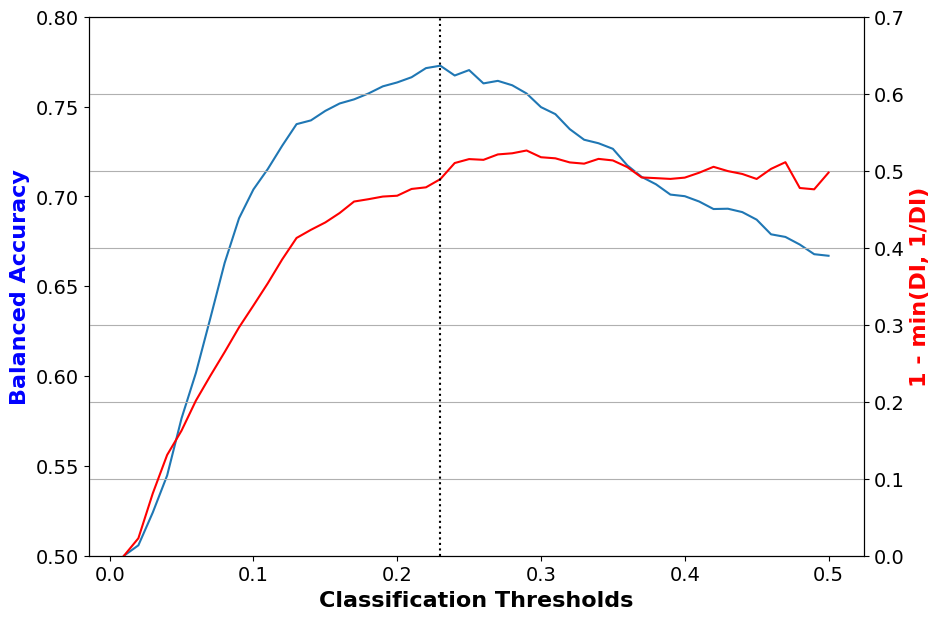

In [155]:
disp_imp = np.array(val_metrics['disp_imp'])
disp_imp_err = 1 - np.minimum(disp_imp, 1/disp_imp)
plot(thresh_arr, 'Classification Thresholds',
     val_metrics['bal_acc'], 'Balanced Accuracy',
     disp_imp_err, '1 - min(DI, 1/DI)')

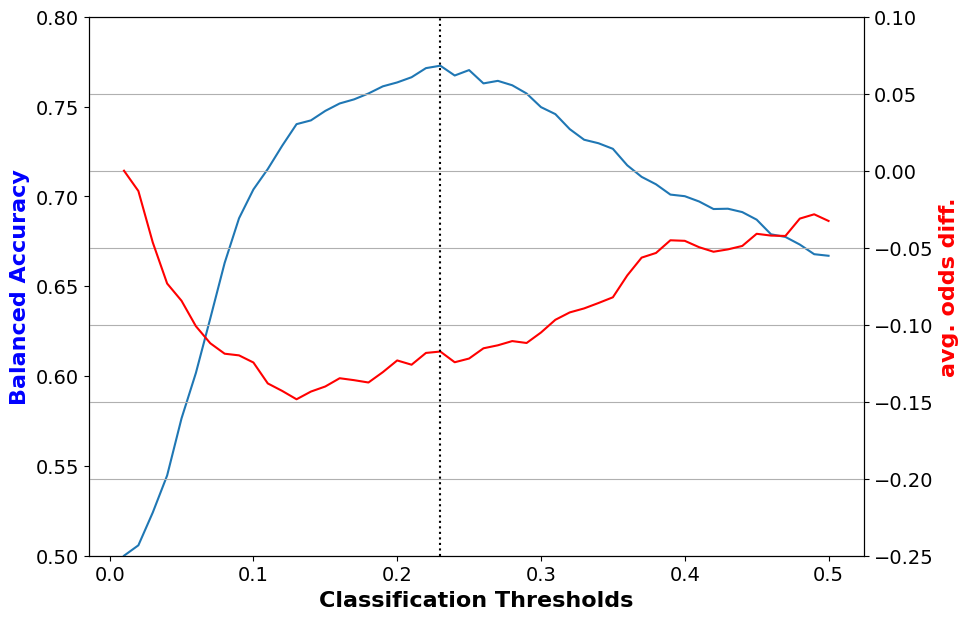

In [156]:
plot(thresh_arr, 'Classification Thresholds',
     val_metrics['bal_acc'], 'Balanced Accuracy',
     val_metrics['avg_odds_diff'], 'avg. odds diff.')

In [157]:
describe_metrics(val_metrics, thresh_arr)

Threshold corresponding to Best balanced accuracy: 0.2300
Best balanced accuracy: 0.7727
Corresponding 1-min(DI, 1/DI) value: 0.4891
Corresponding average odds difference value: -0.1174
Corresponding statistical parity difference value: -0.1952
Corresponding equal opportunity difference value: -0.1076
Corresponding Theil index value: 0.0893


#### 3.3.3. Testing RF model on original data

In [158]:
rf_orig_metrics = test(dataset=dataset_orig_panel19_test,
                       model=rf_orig_panel19,
                       thresh_arr=[thresh_arr[rf_orig_best_ind]])

In [159]:
describe_metrics(rf_orig_metrics, [thresh_arr[rf_orig_best_ind]])

Threshold corresponding to Best balanced accuracy: 0.2300
Best balanced accuracy: 0.7640
Corresponding 1-min(DI, 1/DI) value: 0.5040
Corresponding average odds difference value: -0.1346
Corresponding statistical parity difference value: -0.2121
Corresponding equal opportunity difference value: -0.1141
Corresponding Theil index value: 0.0944


### Section 3 Write Up

**Fairness Metric Summary**

For the logistic regression classifier trained on the original data, the best balanced accuracy was 0.7759 at a threshold of 0.19. The fairness metrics here show:
* **1 - min(DI, 1/DI)**: This metric scored 0.5738, which exceeds the <0.2 threshold typically indiciating fairness. This higher value implies that the model treats groups unequally, suggesting possible bias in predictions.
* **Average Odds Difference**: The metric value of -0.2057 points to an imbalance between false positive and true positive rates for different groups, indicating potential unfairness in classification outcomes.
* **Statistical Parity Difference**:** With a result of -0.2612, the model displays unequal outcome rates across groups, which points to a lack of parity in how outcomes are distributed.
* **Equal Opportunity Difference**: At -0.2288, this metrics shows differing true positive rates between groups, indicating unequal access to favorable predictions.
* **Theil Index**: the score of 0.0921 represents some inequality in benefit distribution across the dataset, considering that the model could be fairer.

For the random forest model, we achieved a balanced accuracy of 0.7640 at a threshold of 0.23. Here’s how each fairness metrics compares:
* **1 - min(DI, 1/DI)**’s value was 0.5040, which still misses the fairness target, though it’s slightly better than the logistics model.
* **Average Odds Difference** of -0.1346 indicates some imbalance in true and false positive rates between groups but less than with logistic regression.
* **Statistical Parity Difference** of -0.2121 shows that one group is receiving more favorable outcomes than the other.
* **Equal Opportunity Difference**: At -0.1141, this value is closer to fair but still suggests slight disparities in error rates between groups.
* **Theil Index**: At 0.0944, the result implies slight unfairness, as it indicates some inequality in how benefits are distributed across individuals. A lower score would suggest a fairer distribution where individuals receive similar levels of benefits.

**Fairness Metric Discussion**

We can determine what metrics to use based on the content and purpose of the MEPS database. Since this dataset pertains to healthcare and patient characteristics it would be important to determine metrics based on prominent factors such as age, race, gender, and other demographics. Based on these groups and other features such as diagnoses we can decide what fairness metrics to use to assure fair treatment across these groups and understand health trends among them for preventative care. If a group is being disproportionately affected by something, it is important that fairness metrics can quantify that unfairness in order to do some form of mitigation. An example would be disparate impact to check these fair outcomes. Another would be equal opportunity to monitor true positives across all groups, to ensure equality. This fits the given data and use case for this project. 

In this case if fairness metrics were in competition, we would have to prioritize the one that is more relevant to the healthcare industry. For example, the metrics mentioned above are high priority across all industries, but particularly for ensuring fairness across various demographics in healthcare. When it comes to ethics, these are major problems today in the industry that need to be combatted so people from all groups have equal opportunity and access to healthcare and that everyone is treated fairly in the system. For example, when it comes to healthcare a false negative in most cases can be a lot more harmful than a false negative since conditions and diseases can go untreated and be fatal. With things like this in mind, we can decide which fairness metrics to prioritize in this use case. 

In situations where we may encounter multiple metrics which appear to have similar definitions, we could start by looking at the mathematical definitions to determine specific differences in calculation. If any are identified, we can develop an understanding of how they affect the final resulting values produced by the metrics, and use that understanding to determine which one may be more appropriate to use in a given case. Additionally, we could do more research on the common use cases of the metrics to find where each one is more often used and try to understand the reasoning for each. From there, we could combine our mathematical and practical understanding of the metrics to decide which one or ones to use for our models.

The two models we tested were Logistic Regression classifier (LR) and Random Forest Classifier (RF). Using the unweighted original data, LR achieved a best balanced accuracy of 0.7759 compared to RF’s 0.7640, which is around a percent lower. Based on this alone, the LR model looks better. Looking at our fairness metrics, the LR model has a significantly lower threshold to best balanced accuracy at 0.19 compared to 0.23 for the RF model. LR has a higher 1-min(DI, 1/DI) value of 0.5738 compared to 0.5040 for RF. For average odds difference, statistical parity difference, and equal opportunity difference, LR has larger magnitude negative values than RF. Both models have similar values for Theil index. Overall, while LR achieves a slightly higher accuracy, it appears that the RF model performs better in terms of fairness, so it appears best to proceed with it.


### [4.](#Table-of-Contents) Additional Model Development

##### 4.1A Load data & create splits for learning/validating/testing model

In [160]:
# Use the same methods from Section 3
(dataset_orig_panel21_train,
 dataset_orig_panel21_val,
 dataset_orig_panel21_test) = MEPSDataset21().split([0.5, 0.8], shuffle=True)

sens_ind = 0
sens_attr = dataset_orig_panel21_train.protected_attribute_names[sens_ind]

unprivileged_groups = [{sens_attr: v} for v in
                       dataset_orig_panel21_train.unprivileged_protected_attributes[sens_ind]]
privileged_groups = [{sens_attr: v} for v in
                     dataset_orig_panel21_train.privileged_protected_attributes[sens_ind]]

#### 4.1B Utilize findings from your EDA to complete any additional model development

In [161]:
describe(dataset_orig_panel21_train, dataset_orig_panel21_val, dataset_orig_panel21_test)


#### Training Dataset shape

(7837, 138)


#### Validation Dataset shape

(4703, 138)


#### Test Dataset shape

(3135, 138)


#### Favorable and unfavorable labels

1.0 0.0


#### Protected attribute names

['RACE']


#### Privileged and unprivileged protected attribute values

[array([1.])] [array([0.])]


#### Dataset feature names

['AGE', 'RACE', 'PCS42', 'MCS42', 'K6SUM42', 'REGION=1', 'REGION=2', 'REGION=3', 'REGION=4', 'SEX=1', 'SEX=2', 'MARRY=1', 'MARRY=2', 'MARRY=3', 'MARRY=4', 'MARRY=5', 'MARRY=6', 'MARRY=7', 'MARRY=8', 'MARRY=9', 'MARRY=10', 'FTSTU=-1', 'FTSTU=1', 'FTSTU=2', 'FTSTU=3', 'ACTDTY=1', 'ACTDTY=2', 'ACTDTY=3', 'ACTDTY=4', 'HONRDC=1', 'HONRDC=2', 'HONRDC=3', 'HONRDC=4', 'RTHLTH=-1', 'RTHLTH=1', 'RTHLTH=2', 'RTHLTH=3', 'RTHLTH=4', 'RTHLTH=5', 'MNHLTH=-1', 'MNHLTH=1', 'MNHLTH=2', 'MNHLTH=3', 'MNHLTH=4', 'MNHLTH=5', 'HIBPDX=-1', 'HIBPDX=1', 'HIBPDX=2', 'CHDDX=-1', 'CHDDX=1', 'CHDDX=2', 'ANGIDX=-1', 'ANGIDX=1', 'ANGIDX=2', 'MIDX=-1', 'MIDX=1', 'MIDX=2', 'OHRTDX=-1', 'OHRTDX=1', 'OHRTDX=2', 'STRKDX=-1', 'STRKDX=1', 'STRKDX=2', 'EMPHDX=-1', 'EMPHDX=1', 'EMPHDX=2', 'CHBRON=-1', 'CHBRON=1', 'CHBRON=2', 'CHOLDX=-1', 'CHOLDX=1', 'CHOLDX=2', 'CANCERDX=-1', 'CANCERDX=1', 'CANCERDX=2', 'DIABDX=-1', 'DIABDX=1', 'DIABDX=2', 'JTPAIN=-1', 'JTPAIN=1', 'JTPAIN=2', 'ARTHDX=-1', 'ARTHDX=1', 'ARTHDX=2', 'ARTHTYPE=-1'

In [162]:
metric_orig_panel21_train = BinaryLabelDatasetMetric(
        dataset_orig_panel21_train,
        unprivileged_groups=unprivileged_groups,
        privileged_groups=privileged_groups)
explainer_orig_panel21_train = MetricTextExplainer(metric_orig_panel21_train)

print(explainer_orig_panel21_train.disparate_impact())

Disparate impact (probability of favorable outcome for unprivileged instances / probability of favorable outcome for privileged instances): 0.4856132419740048


We wanted to select specific features we believed were the most correlated to the target variable. We selected the features with the top 25 largest positive and negative correlation with Utilization and attempted to drop all other features and retrain our models, but we had some issues with the format of the dataset and the protected attribute. Our goal was to only keep the relevant columns we stored in the feature list.

In [163]:
top_corr_cols = top_25.index.tolist()
top_corr_cols.remove('UTILIZATION')
top_corr_cols

['WLKLIM_1',
 'ARTHDX_1',
 'ACTLIM_1',
 'AGE',
 'JTPAIN_1',
 'ACTDTY_4',
 'HIBPDX_1',
 'CHOLDX_1',
 'SOCLIM_1',
 'EMPST_4',
 'PHQ242',
 'CANCERDX_1',
 'ARTHTYPE_2',
 'COGLIM_1',
 'OHRTDX_1',
 'DIABDX_1',
 'CHDDX_1',
 'ARTHTYPE_3',
 'RTHLTH_4',
 'ADSMOK42_2',
 'MARRY_2',
 'STRKDX_1',
 'RTHLTH_5',
 'ADHDADDX_-1']

In [164]:
bottom_corr_cols = bottom_25.index.tolist()
bottom_corr_cols

['WLKLIM_2',
 'ARTHTYPE_-1',
 'SOCLIM_2',
 'ACTLIM_2',
 'ADSMOK42_-1',
 'K6SUM42_-1',
 'CANCERDX_-1',
 'EMPHDX_-1',
 'MIDX_-1',
 'ANGIDX_-1',
 'CHOLDX_-1',
 'OHRTDX_-1',
 'DIABDX_-1',
 'CHDDX_-1',
 'ARTHDX_-1',
 'HIBPDX_-1',
 'STRKDX_-1',
 'RTHLTH_1',
 'JTPAIN_-1',
 'CHBRON_-1',
 'COGLIM_-1',
 'HONRDC_3',
 'ADHDADDX_2',
 'ACTDTY_3',
 'EMPST_-1']

In [165]:
feature_list = top_corr_cols + bottom_corr_cols
feature_list = [item.replace('_', '=')if '_' in item else item for item in feature_list]
feature_list

['WLKLIM=1',
 'ARTHDX=1',
 'ACTLIM=1',
 'AGE',
 'JTPAIN=1',
 'ACTDTY=4',
 'HIBPDX=1',
 'CHOLDX=1',
 'SOCLIM=1',
 'EMPST=4',
 'PHQ242',
 'CANCERDX=1',
 'ARTHTYPE=2',
 'COGLIM=1',
 'OHRTDX=1',
 'DIABDX=1',
 'CHDDX=1',
 'ARTHTYPE=3',
 'RTHLTH=4',
 'ADSMOK42=2',
 'MARRY=2',
 'STRKDX=1',
 'RTHLTH=5',
 'ADHDADDX=-1',
 'WLKLIM=2',
 'ARTHTYPE=-1',
 'SOCLIM=2',
 'ACTLIM=2',
 'ADSMOK42=-1',
 'K6SUM42=-1',
 'CANCERDX=-1',
 'EMPHDX=-1',
 'MIDX=-1',
 'ANGIDX=-1',
 'CHOLDX=-1',
 'OHRTDX=-1',
 'DIABDX=-1',
 'CHDDX=-1',
 'ARTHDX=-1',
 'HIBPDX=-1',
 'STRKDX=-1',
 'RTHLTH=1',
 'JTPAIN=-1',
 'CHBRON=-1',
 'COGLIM=-1',
 'HONRDC=3',
 'ADHDADDX=2',
 'ACTDTY=3',
 'EMPST=-1']

In [166]:
from collections import Counter
prefixes = [feat.split('=')[0] for feat in feature_list]
prefix_counts = Counter(prefixes)
most_common_prefixes = prefix_counts.most_common(5)

features_to_keep = [tup[0] for tup in most_common_prefixes]


(dataset_orig_panel21_train_features_to_keep,
 dataset_orig_panel21_val_features_to_keep,
 dataset_orig_panel21_test_features_to_keep) = MEPSDataset21(features_to_keep = features_to_keep).split([0.5, 0.8], shuffle=True)


### 4.2. Learning a Logistic Regression (LR) classifier on original data

##### 4.2.1 Training LR model on original data

In [167]:
dataset = dataset_orig_panel21_train_features_to_keep
model = make_pipeline(StandardScaler(),
                      LogisticRegression(solver='liblinear', random_state=1))
fit_params = {'logisticregression__sample_weight': dataset.instance_weights}

lr_orig_panel21 = model.fit(dataset.features, dataset.labels.ravel(), **fit_params)

##### 4.2.2 Validating LR model on original data

In [168]:
thresh_arr = np.linspace(0.01, 0.5, 50)
val_metrics = test(dataset=dataset_orig_panel21_val_features_to_keep,
                   model=lr_orig_panel21,
                   thresh_arr=thresh_arr)
lr_orig_panel21_best_ind = np.argmax(val_metrics['bal_acc'])

Calculate and plot disparate impact

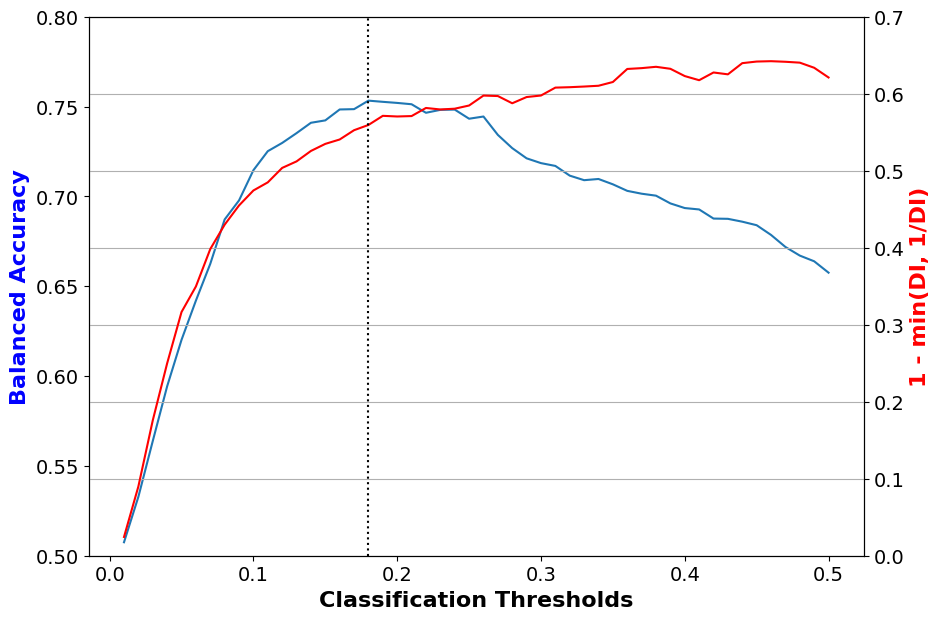

In [169]:
disp_imp = np.array(val_metrics['disp_imp'])
disp_imp_err = 1 - np.minimum(disp_imp, 1/disp_imp)
plot(thresh_arr, 'Classification Thresholds',
     val_metrics['bal_acc'], 'Balanced Accuracy',
     disp_imp_err, '1 - min(DI, 1/DI)')

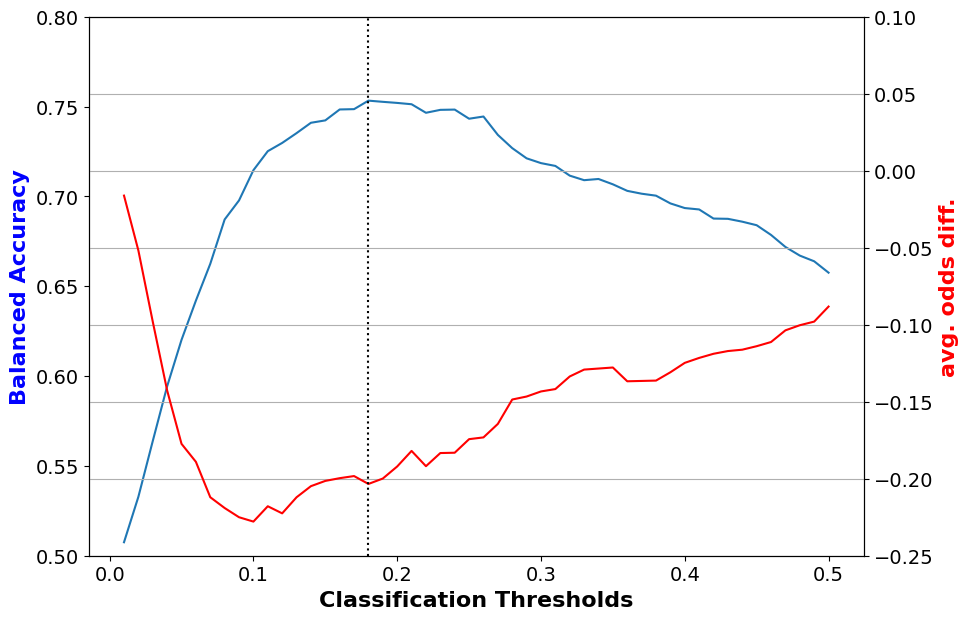

In [170]:
plot(thresh_arr, 'Classification Thresholds',
     val_metrics['bal_acc'], 'Balanced Accuracy',
     val_metrics['avg_odds_diff'], 'avg. odds diff.')

In [171]:
describe_metrics(val_metrics, thresh_arr)

Threshold corresponding to Best balanced accuracy: 0.1800
Best balanced accuracy: 0.7533
Corresponding 1-min(DI, 1/DI) value: 0.5594
Corresponding average odds difference value: -0.2034
Corresponding statistical parity difference value: -0.2568
Corresponding equal opportunity difference value: -0.2133
Corresponding Theil index value: 0.0933


#### 4.2.3 Testing LR model on original data

In [172]:
lr_orig_panel21_metrics = test(dataset=dataset_orig_panel21_test_features_to_keep,
                       model=lr_orig_panel21,
                       thresh_arr=[thresh_arr[lr_orig_best_ind]])

In [173]:
describe_metrics(lr_orig_panel21_metrics, [thresh_arr[lr_orig_best_ind]])

Threshold corresponding to Best balanced accuracy: 0.1900
Best balanced accuracy: 0.7460
Corresponding 1-min(DI, 1/DI) value: 0.6032
Corresponding average odds difference value: -0.2140
Corresponding statistical parity difference value: -0.2672
Corresponding equal opportunity difference value: -0.2239
Corresponding Theil index value: 0.0935


### 4.3. Learning a Random Forest (RF) classifier on original data

#### 4.3.1 Training RF model on original data

In [174]:
dataset = dataset_orig_panel21_train_features_to_keep
model = make_pipeline(StandardScaler(),
                      RandomForestClassifier(n_estimators=500, min_samples_leaf=25))
fit_params = {'randomforestclassifier__sample_weight': dataset.instance_weights}
rf_orig_panel21 = model.fit(dataset.features, dataset.labels.ravel(), **fit_params)

#### 4.3.2 Validating RF model on original data

In [175]:
thresh_arr = np.linspace(0.01, 0.5, 50)
val_metrics = test(dataset=dataset_orig_panel21_val_features_to_keep,
                   model=rf_orig_panel21,
                   thresh_arr=thresh_arr)
rf_orig_best_ind = np.argmax(val_metrics['bal_acc'])

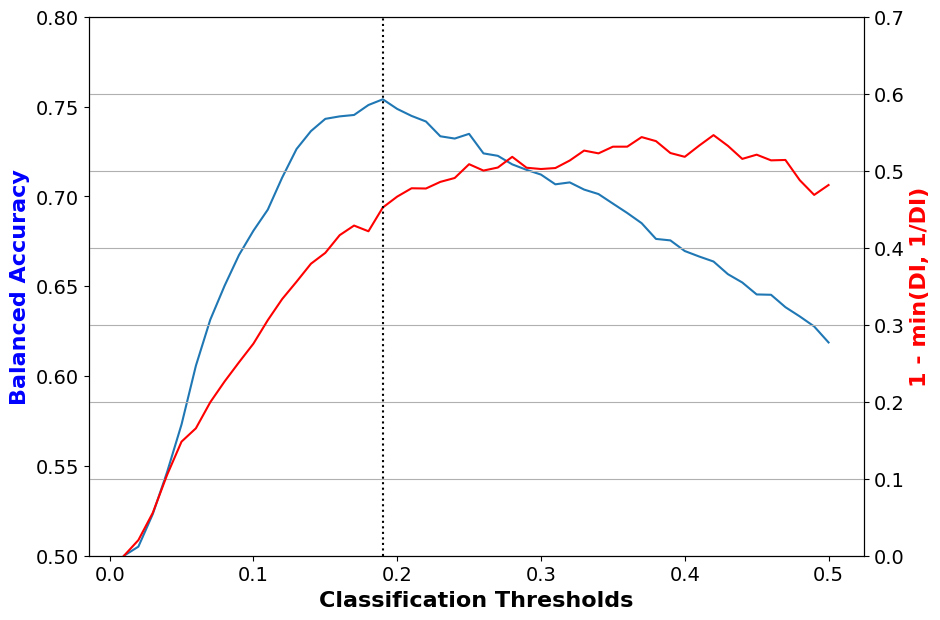

In [176]:
disp_imp = np.array(val_metrics['disp_imp'])
disp_imp_err = 1 - np.minimum(disp_imp, 1/disp_imp)
plot(thresh_arr, 'Classification Thresholds',
     val_metrics['bal_acc'], 'Balanced Accuracy',
     disp_imp_err, '1 - min(DI, 1/DI)')

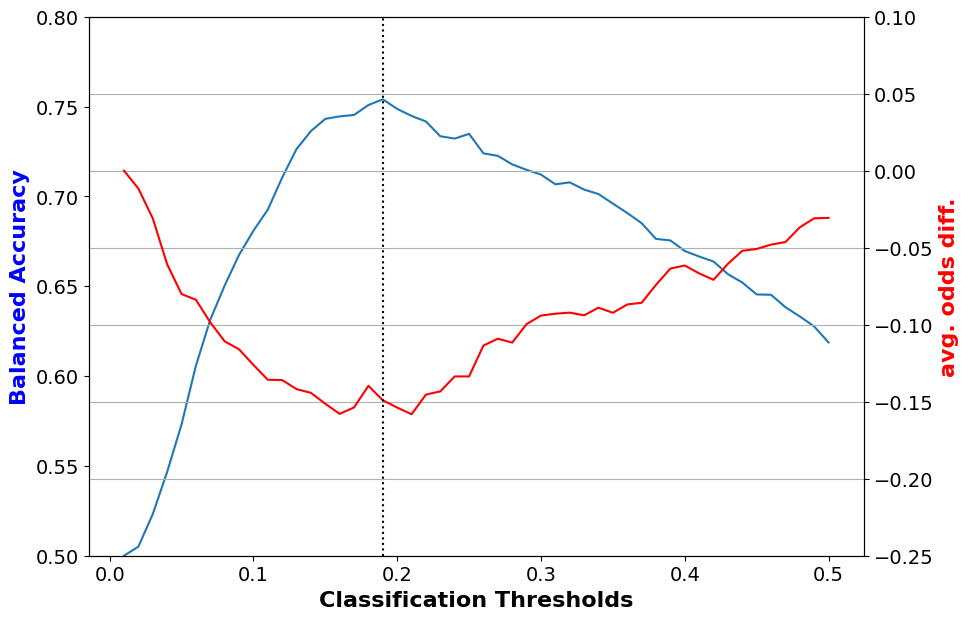

In [177]:
plot(thresh_arr, 'Classification Thresholds',
     val_metrics['bal_acc'], 'Balanced Accuracy',
     val_metrics['avg_odds_diff'], 'avg. odds diff.')

In [178]:
describe_metrics(val_metrics, thresh_arr)

Threshold corresponding to Best balanced accuracy: 0.1900
Best balanced accuracy: 0.7540
Corresponding 1-min(DI, 1/DI) value: 0.4523
Corresponding average odds difference value: -0.1491
Corresponding statistical parity difference value: -0.2136
Corresponding equal opportunity difference value: -0.1446
Corresponding Theil index value: 0.0901


#### 4.3.3 Testing RF model on original data

In [179]:
rf_orig_panel21_metrics = test(dataset=dataset_orig_panel21_test_features_to_keep,
                       model=rf_orig_panel21,
                       thresh_arr=[thresh_arr[rf_orig_best_ind]])

In [180]:
describe_metrics(rf_orig_panel21_metrics, [thresh_arr[rf_orig_best_ind]])

Threshold corresponding to Best balanced accuracy: 0.1900
Best balanced accuracy: 0.7471
Corresponding 1-min(DI, 1/DI) value: 0.4946
Corresponding average odds difference value: -0.1885
Corresponding statistical parity difference value: -0.2378
Corresponding equal opportunity difference value: -0.2055
Corresponding Theil index value: 0.0892


### Section 4 Write Up here

**1. For both the logistic regression and random forest classifiers learned on the original data, please include the results of your fairness metrics. For _each_ metric result briefly describe (1-2 sentences) if you saw any differences from your results in Part 3, and what that might mean.**

_Logistic Regression's Fairness Metrics_
   * Threshold corresponding to Best balanced accuracy: At a threshold of 0.1900, the classifier achieves its optimal balance between sensitivity and specificity.
   * Best balanced accuracy: The model achieves a balanced accuracy of 0.7460, indicating a moderate balance between true positive and true negative rates.
   * Corresponding 1-min(DI, 1/DI) value: The value of 0.6032 shows significant disparity in positive outcome rates between groups.
   * Corresponding average odds difference value: The value of -0.2140 shows inequality in true positive and false positive rates across groups.
   * Corresponding statistical parity difference value: A value of -0.2672 indicates a substantial difference in positive prediction rates between groups.
   * Corresponding equal opportunity difference value: A value of -0.2239 suggests unequal true positive rates between groups, impacting fairness.
   * Corresponding Theil index value: The index of 0.0935 implies low inequality in the overall predictive distribution.

_Random Forest's Fairness Metrics_
   * Threshold corresponding to Best balanced accuracy: Like logistic regression, the optimal threshold for balanced accuracy is 0.1900.
   * Best balanced accuracy: The model slightly outperforms logistic regression, achieving a balanced accuracy of 0.7471.
   * Corresponding 1-min(DI, 1/DI) value: The value of 0.4946 shows higher disparity in positive outcome rates compared to logistic regression.
   * Corresponding average odds difference value: The value of -0.1885 indicates less inequality in true positive and false positive rates than logistic regression.
   * Corresponding statistical parity difference value: A value of -0.2378 shows a smaller difference in positive prediction rates compared to logistic regression.
   * Corresponding equal opportunity difference value: A value of -0.2055 indicates slightly better fairness in true positive rates compared to logistic regression.
   * Corresponding Theil index value: The index of 0.0892 suggests slightly lower inequality in the overall predictive distribution compared to logistic regression.

When we selected the top 25 features based on correlation with utilization and retrained the models, the balanced accuracy and fairness metrics differed slightly compared to Part 3. For example, the logistic regression's balanced accuracy dropped from 0.7759 to 0.7460, and fairness metrics like statistical parity and equal opportunity difference worsened. This suggests that removing features may have reduced the model's ability to generalize and increased bias. Random forest models also showed lower balanced accuracy (0.7640 vs. 0.7471) but improved fairness slightly. This indicates feature selection can impact both performance and fairness, depending on the dataset and model.

    
**2. Based on this, would you make any recommendations during model development? Does it change which model and fairness metric would be the best to proceed with?** (Please write at least one paragraph)

Based on the results, both logistic regression and random forest perform similarly in terms of balanced accuracy, with random forest slightly outperforming logistic regression (0.7471 vs. 0.7460). However, when evaluating fairness metrics, random forest shows slight improvements in fairness, including lower average odds difference (-0.1885 vs. -0.2140), statistical parity difference (-0.2378 vs. -0.2672), and equal opportunity difference (-0.2055 vs. -0.2239). These suggest that random forest makes fairer predictions across groups. That said, the 1-min(DI, 1/DI) value is better for logistic regression (0.6032 vs. 0.4946), meaning it less disparity in positive outcomes between groups. However, this advantage may not outweigh the overall imporvment in other fairness metrics observed in the random forest model.

In terms of recommendations, further steps could innclude exploring additional preprocessing methods to reduce bias in the data or tuning the threshold to balance accuracy and fairness more effectively. Techniques like reweighing, adversarial debiasing, or adding fairness constraints to the model training could also be explored to enhance fairness metrics further.

Given the slightly better fairness performance of the random forest model, it may be the better choice moving forward, but the decision depends on which fairness metric is prioritized. For example, if minimizing disparities in positive outcomes (1-min(DI, 1/DI)) is most critical, logistic regression might still be preferable. However, for a more balanced improvement across multiple fairness measures, random forest appears to be the better option.

### [5.](#Table-of-Contents) Bias Mitigation

### [5A.](#Table-of-Contents) Bias mitigation using pre-processing technique, Reweighing - AIF360 Example

#### 5A.1 Transform data

In [181]:
RW = Reweighing(unprivileged_groups=unprivileged_groups,
                privileged_groups=privileged_groups)
dataset_transf_panel19_train = RW.fit_transform(dataset_orig_panel19_train)

Metrics for transformed data

In [182]:
metric_transf_panel19_train = BinaryLabelDatasetMetric(
        dataset_transf_panel19_train,
        unprivileged_groups=unprivileged_groups,
        privileged_groups=privileged_groups)
explainer_transf_panel19_train = MetricTextExplainer(metric_transf_panel19_train)

print(explainer_transf_panel19_train.disparate_impact())

Disparate impact (probability of favorable outcome for unprivileged instances / probability of favorable outcome for privileged instances): 1.0


#### **5A.2. Learning a Logistic Regression (LR) classifier on data transformed by reweighing**

##### 5A.2.1. Training LR model after reweighing

In [183]:
dataset = dataset_transf_panel19_train
model = make_pipeline(StandardScaler(),
                      LogisticRegression(solver='liblinear', random_state=1))
fit_params = {'logisticregression__sample_weight': dataset.instance_weights}
lr_transf_panel19 = model.fit(dataset.features, dataset.labels.ravel(), **fit_params)

##### 5A.2.2. Validating  LR model after reweighing

In [184]:
thresh_arr = np.linspace(0.01, 0.5, 50)
val_metrics = test(dataset=dataset_orig_panel19_val,
                   model=lr_transf_panel19,
                   thresh_arr=thresh_arr)
lr_transf_best_ind = np.argmax(val_metrics['bal_acc'])

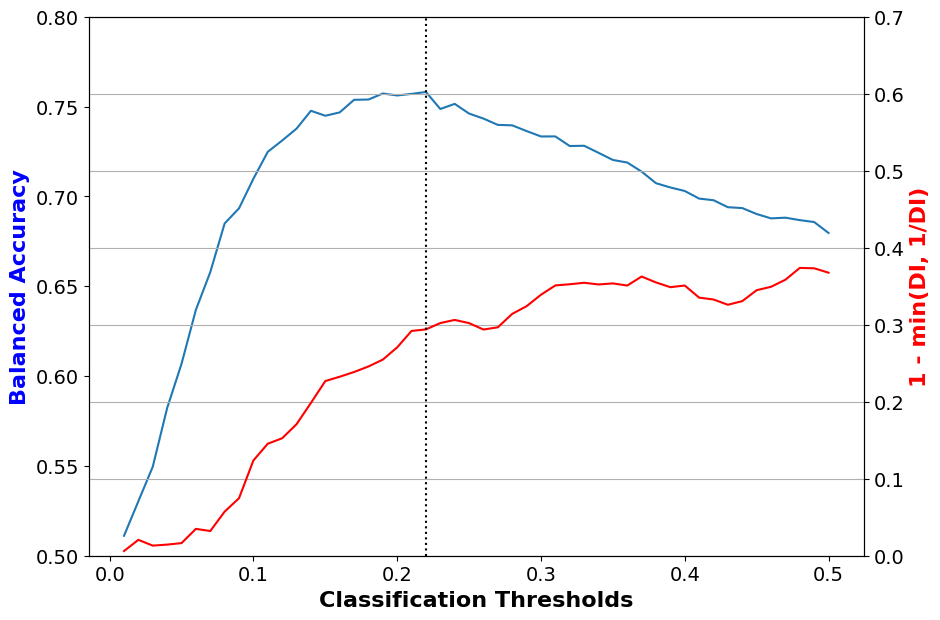

In [185]:
disp_imp = np.array(val_metrics['disp_imp'])
disp_imp_err = 1 - np.minimum(disp_imp, 1/disp_imp)
plot(thresh_arr, 'Classification Thresholds',
     val_metrics['bal_acc'], 'Balanced Accuracy',
     disp_imp_err, '1 - min(DI, 1/DI)')

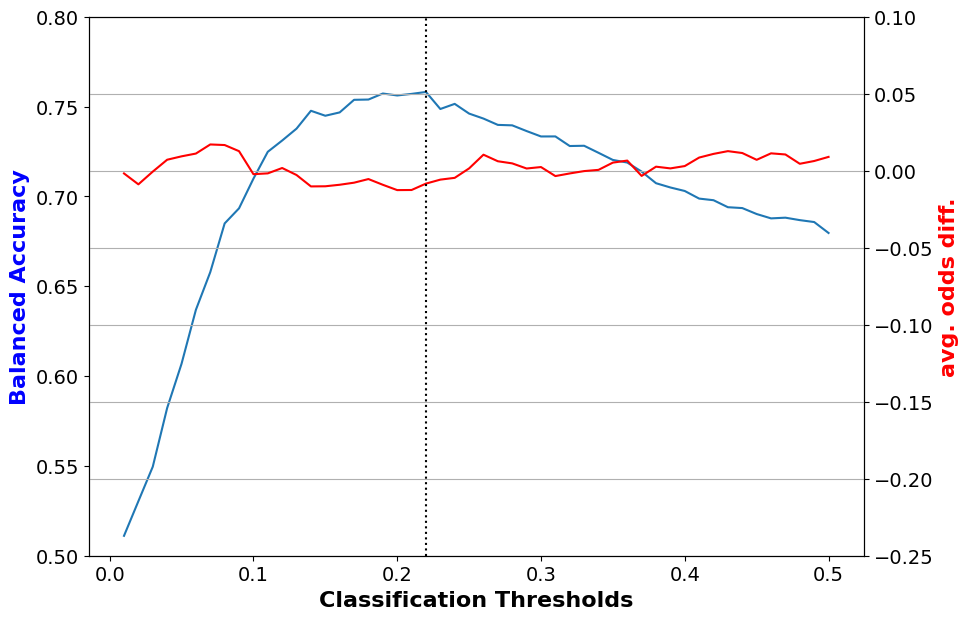

In [186]:
plot(thresh_arr, 'Classification Thresholds',
     val_metrics['bal_acc'], 'Balanced Accuracy',
     val_metrics['avg_odds_diff'], 'avg. odds diff.')

In [187]:
describe_metrics(val_metrics, thresh_arr)

Threshold corresponding to Best balanced accuracy: 0.2200
Best balanced accuracy: 0.7581
Corresponding 1-min(DI, 1/DI) value: 0.2939
Corresponding average odds difference value: -0.0084
Corresponding statistical parity difference value: -0.0992
Corresponding equal opportunity difference value: 0.0242
Corresponding Theil index value: 0.0938


##### 5A.2.3. Testing  LR model after reweighing

In [188]:
lr_transf_metrics = test(dataset=dataset_orig_panel19_test,
                         model=lr_transf_panel19,
                         thresh_arr=[thresh_arr[lr_transf_best_ind]])

In [189]:
describe_metrics(lr_transf_metrics, [thresh_arr[lr_transf_best_ind]])

Threshold corresponding to Best balanced accuracy: 0.2200
Best balanced accuracy: 0.7539
Corresponding 1-min(DI, 1/DI) value: 0.2482
Corresponding average odds difference value: -0.0151
Corresponding statistical parity difference value: -0.0872
Corresponding equal opportunity difference value: -0.0035
Corresponding Theil index value: 0.0966


The fairness metrics for the logistic regression model learned after reweighing are well improved, and thus the model is much more fair relative to the logistic regression model learned from the original data.

##### 5A.3. Learning a Random Forest (RF) classifier on data transformed by reweighing

##### 5A.3.1. Training  RF model after reweighing

In [190]:
dataset = dataset_transf_panel19_train
model = make_pipeline(StandardScaler(),
                      RandomForestClassifier(n_estimators=500, min_samples_leaf=25))
fit_params = {'randomforestclassifier__sample_weight': dataset.instance_weights}
rf_transf_panel19 = model.fit(dataset.features, dataset.labels.ravel(), **fit_params)

##### 5A.3.2 Validating RF model after reweighing

In [191]:
thresh_arr = np.linspace(0.01, 0.5, 50)
val_metrics = test(dataset=dataset_orig_panel19_val,
                   model=rf_transf_panel19,
                   thresh_arr=thresh_arr)
rf_transf_best_ind = np.argmax(val_metrics['bal_acc'])

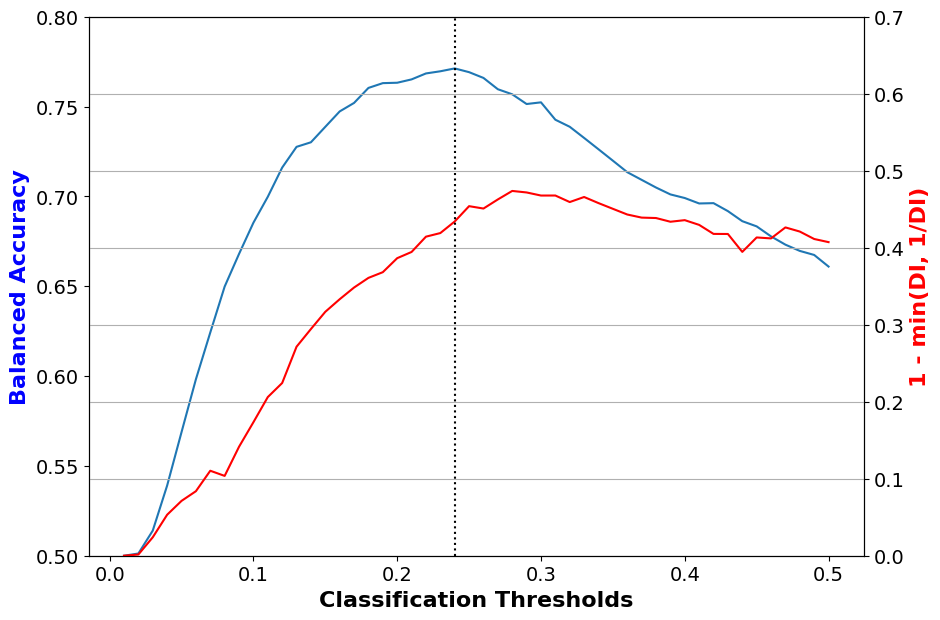

In [192]:
disp_imp = np.array(val_metrics['disp_imp'])
disp_imp_err = 1 - np.minimum(disp_imp, 1/disp_imp)
plot(thresh_arr, 'Classification Thresholds',
     val_metrics['bal_acc'], 'Balanced Accuracy',
     disp_imp_err, '1 - min(DI, 1/DI)')

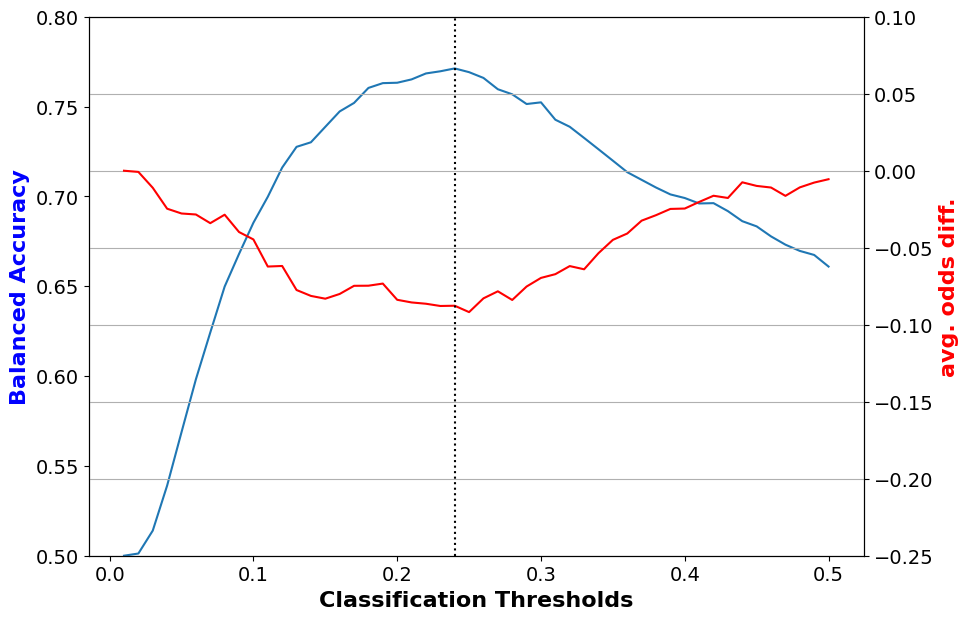

In [193]:
plot(thresh_arr, 'Classification Thresholds',
     val_metrics['bal_acc'], 'Balanced Accuracy',
     val_metrics['avg_odds_diff'], 'avg. odds diff.')

In [194]:
describe_metrics(val_metrics, thresh_arr)

Threshold corresponding to Best balanced accuracy: 0.2400
Best balanced accuracy: 0.7712
Corresponding 1-min(DI, 1/DI) value: 0.4341
Corresponding average odds difference value: -0.0877
Corresponding statistical parity difference value: -0.1640
Corresponding equal opportunity difference value: -0.0808
Corresponding Theil index value: 0.0901


##### 5A.3.3 Testing RF model after reweighing

In [195]:
rf_transf_metrics = test(dataset=dataset_orig_panel19_test,
                         model=rf_transf_panel19,
                         thresh_arr=[thresh_arr[rf_transf_best_ind]])

In [196]:
describe_metrics(rf_transf_metrics, [thresh_arr[rf_transf_best_ind]])

Threshold corresponding to Best balanced accuracy: 0.2400
Best balanced accuracy: 0.7637
Corresponding 1-min(DI, 1/DI) value: 0.4319
Corresponding average odds difference value: -0.0973
Corresponding statistical parity difference value: -0.1694
Corresponding equal opportunity difference value: -0.0868
Corresponding Theil index value: 0.0951


Once again, the model learned from the transformed data is fairer than that learned from the original data. However, the random forest model learned from the transformed data is still relatively unfair as compared to the logistic regression model learned from the transformed data.

### [5B.](#Table-of-Contents) Prejudice Remover (in-processing bias mitigation) -  AIF360 Example

#### 5B.1 Learning a Prejudice Remover (PR) model on orginal data

##### 5B.1.1. Training a PR model

In [197]:
model = PrejudiceRemover(sensitive_attr=sens_attr, eta=25.0)
pr_orig_scaler = StandardScaler()

dataset = dataset_orig_panel19_train.copy()
dataset.features = pr_orig_scaler.fit_transform(dataset.features)

pr_orig_panel19 = model.fit(dataset)

##### 5B.1.2. Validating a PR model

In [198]:
thresh_arr = np.linspace(0.01, 0.50, 50)

dataset = dataset_orig_panel19_val.copy()
dataset.features = pr_orig_scaler.transform(dataset.features)

val_metrics = test(dataset=dataset,
                   model=pr_orig_panel19,
                   thresh_arr=thresh_arr)
pr_orig_best_ind = np.argmax(val_metrics['bal_acc'])

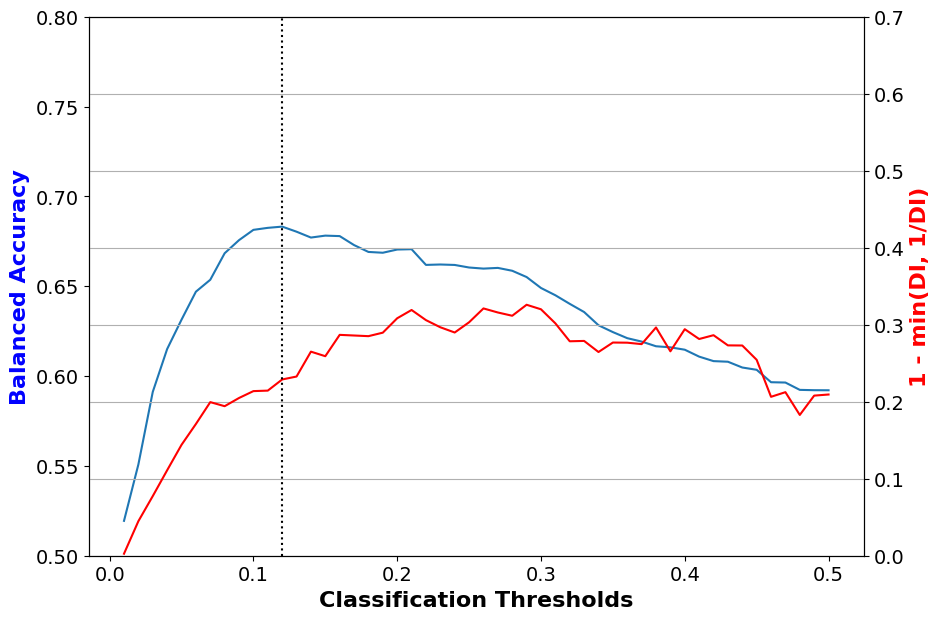

In [199]:
disp_imp = np.array(val_metrics['disp_imp'])
disp_imp_err = 1 - np.minimum(disp_imp, 1/disp_imp)
plot(thresh_arr, 'Classification Thresholds',
     val_metrics['bal_acc'], 'Balanced Accuracy',
     disp_imp_err, '1 - min(DI, 1/DI)')

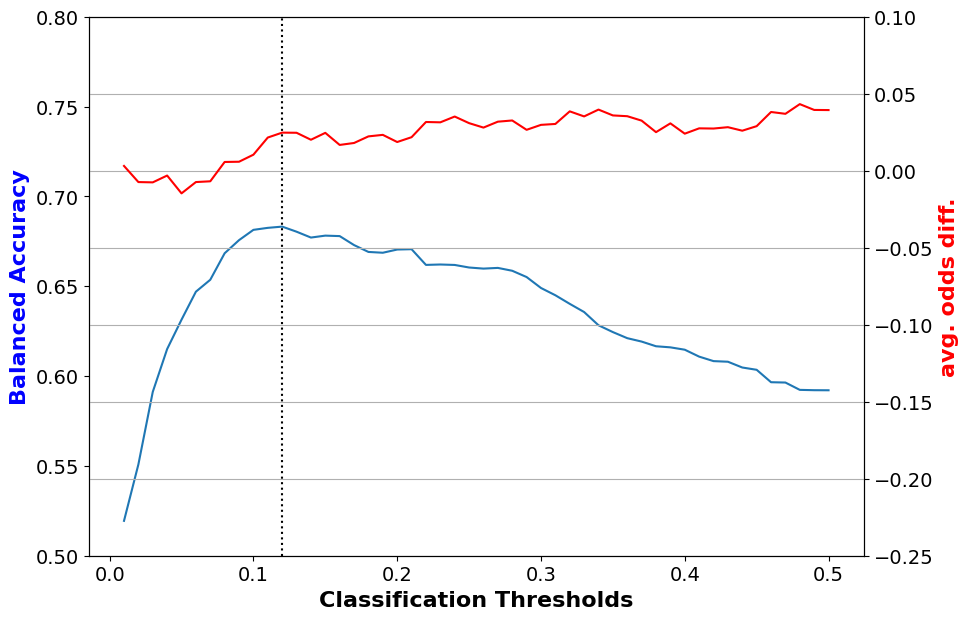

In [200]:
plot(thresh_arr, 'Classification Thresholds',
     val_metrics['bal_acc'], 'Balanced Accuracy',
     val_metrics['avg_odds_diff'], 'avg. odds diff.')

In [201]:
describe_metrics(val_metrics, thresh_arr)

Threshold corresponding to Best balanced accuracy: 0.1200
Best balanced accuracy: 0.6832
Corresponding 1-min(DI, 1/DI) value: 0.2289
Corresponding average odds difference value: 0.0247
Corresponding statistical parity difference value: -0.0840
Corresponding equal opportunity difference value: 0.1172
Corresponding Theil index value: 0.1119


##### 5B.1.3. Testing PR model

In [202]:
dataset = dataset_orig_panel19_test.copy()
dataset.features = pr_orig_scaler.transform(dataset.features)

pr_orig_metrics = test(dataset=dataset,
                       model=pr_orig_panel19,
                       thresh_arr=[thresh_arr[pr_orig_best_ind]])

In [203]:
describe_metrics(pr_orig_metrics, [thresh_arr[pr_orig_best_ind]])

Threshold corresponding to Best balanced accuracy: 0.1200
Best balanced accuracy: 0.6881
Corresponding 1-min(DI, 1/DI) value: 0.1594
Corresponding average odds difference value: 0.0522
Corresponding statistical parity difference value: -0.0568
Corresponding equal opportunity difference value: 0.1479
Corresponding Theil index value: 0.1107


As in the case of reweighing, prejudice remover results in a fair model. However, it has come at the expense of relatively lower balanced accuracy.

### [5C.](#Table-of-Contents) Bias mitigation using a technique of your own


In [204]:
from aif360.datasets import AdultDataset, GermanDataset, CompasDataset
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.metrics import ClassificationMetric
from aif360.metrics.utils import compute_boolean_conditioning_vector

from aif360.algorithms.preprocessing.optim_preproc_helpers.data_preproc_functions\
                import load_preproc_data_adult, load_preproc_data_compas
from aif360.algorithms.postprocessing.calibrated_eq_odds_postprocessing import CalibratedEqOddsPostprocessing

from tqdm import tqdm

from sklearn.preprocessing import scale
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score


In [205]:
# Placeholder for predicted and transformed datasets
dataset_orig_panel19_train_pred = dataset_orig_panel19_train.copy(deepcopy=True)
dataset_orig_panel19_val_pred = dataset_orig_panel19_val.copy(deepcopy=True)
dataset_orig_panel19_test_pred = dataset_orig_panel19_test.copy(deepcopy=True)

dataset_new_valid_pred = dataset_orig_panel19_val.copy(deepcopy=True)
dataset_new_test_pred = dataset_orig_panel19_test.copy(deepcopy=True)

# Logistic regression classifier and predictions for training data
scale_orig = StandardScaler()
X_train = scale_orig.fit_transform(dataset_orig_panel19_train.features)
y_train = dataset_orig_panel19_train.labels.ravel()
lmod = LogisticRegression()
lmod.fit(X_train, y_train)

fav_idx = np.where(lmod.classes_ == dataset_orig_panel19_train.favorable_label)[0][0]
y_train_pred_prob = lmod.predict_proba(X_train)[:,fav_idx]

# Prediction probs for validation and testing data
X_valid = scale_orig.transform(dataset_orig_panel19_val.features)
y_valid_pred_prob = lmod.predict_proba(X_valid)[:,fav_idx]

X_test = scale_orig.transform(dataset_orig_panel19_test.features)
y_test_pred_prob = lmod.predict_proba(X_test)[:,fav_idx]

class_thresh = 0.5
dataset_orig_panel19_train_pred.scores = y_train_pred_prob.reshape(-1,1)
dataset_orig_panel19_val_pred.scores = y_valid_pred_prob.reshape(-1,1)
dataset_orig_panel19_test_pred.scores = y_test_pred_prob.reshape(-1,1)

y_train_pred = np.zeros_like(dataset_orig_panel19_train_pred.labels)
y_train_pred[y_train_pred_prob >= class_thresh] = dataset_orig_panel19_train_pred.favorable_label
y_train_pred[~(y_train_pred_prob >= class_thresh)] = dataset_orig_panel19_train_pred.unfavorable_label
dataset_orig_panel19_train_pred.labels = y_train_pred

y_valid_pred = np.zeros_like(dataset_orig_panel19_val_pred.labels)
y_valid_pred[y_valid_pred_prob >= class_thresh] = dataset_orig_panel19_val_pred.favorable_label
y_valid_pred[~(y_valid_pred_prob >= class_thresh)] = dataset_orig_panel19_val_pred.unfavorable_label
dataset_orig_panel19_val_pred.labels = y_valid_pred
    
y_test_pred = np.zeros_like(dataset_orig_panel19_test_pred.labels)
y_test_pred[y_test_pred_prob >= class_thresh] = dataset_orig_panel19_test_pred.favorable_label
y_test_pred[~(y_test_pred_prob >= class_thresh)] = dataset_orig_panel19_test_pred.unfavorable_label
dataset_orig_panel19_test_pred.labels = y_test_pred

In [206]:
cm_pred_train = ClassificationMetric(dataset_orig_panel19_train, dataset_orig_panel19_train_pred,
                             unprivileged_groups=unprivileged_groups,
                             privileged_groups=privileged_groups)
display(Markdown("#### Original-Predicted training dataset"))
print("Difference in GFPR between unprivileged and privileged groups")
print(cm_pred_train.difference(cm_pred_train.generalized_false_positive_rate))
print("Difference in GFNR between unprivileged and privileged groups")
print(cm_pred_train.difference(cm_pred_train.generalized_false_negative_rate))

cm_pred_valid = ClassificationMetric(dataset_orig_panel19_val, dataset_orig_panel19_val_pred,
                             unprivileged_groups=unprivileged_groups,
                             privileged_groups=privileged_groups)
display(Markdown("#### Original-Predicted validation dataset"))
print("Difference in GFPR between unprivileged and privileged groups")
print(cm_pred_valid.difference(cm_pred_valid.generalized_false_positive_rate))
print("Difference in GFNR between unprivileged and privileged groups")
print(cm_pred_valid.difference(cm_pred_valid.generalized_false_negative_rate))

cm_pred_test = ClassificationMetric(dataset_orig_panel19_test, dataset_orig_panel19_test_pred,
                             unprivileged_groups=unprivileged_groups,
                             privileged_groups=privileged_groups)
display(Markdown("#### Original-Predicted testing dataset"))
print("Difference in GFPR between unprivileged and privileged groups")
print(cm_pred_test.difference(cm_pred_test.generalized_false_positive_rate))
print("Difference in GFNR between unprivileged and privileged groups")
print(cm_pred_test.difference(cm_pred_test.generalized_false_negative_rate))

#### Original-Predicted training dataset

Difference in GFPR between unprivileged and privileged groups
-0.08417391772834491
Difference in GFNR between unprivileged and privileged groups
0.1469642918490432


#### Original-Predicted validation dataset

Difference in GFPR between unprivileged and privileged groups
-0.09655859068108669
Difference in GFNR between unprivileged and privileged groups
0.10809000871870933


#### Original-Predicted testing dataset

Difference in GFPR between unprivileged and privileged groups
-0.09363084270132367
Difference in GFNR between unprivileged and privileged groups
0.16657069157506788


In [207]:
# cost constraint of fnr will optimize generalized false negative rates, that of
# fpr will optimize generalized false positive rates, and weighted will optimize
# a weighted combination of both
cost_constraint = "fnr" # "fnr", "fpr", "weighted"
#random seed for calibrated equal odds prediction
randseed = 12345679 

cpp = CalibratedEqOddsPostprocessing(privileged_groups = privileged_groups,
                                     unprivileged_groups = unprivileged_groups,
                                     cost_constraint=cost_constraint,
                                     seed=randseed)
cpp = cpp.fit(dataset_orig_panel19_val,  dataset_orig_panel19_val_pred)

In [208]:
dataset_transf_valid_pred = cpp.predict(dataset_orig_panel19_val_pred)
dataset_transf_test_pred = cpp.predict(dataset_orig_panel19_test_pred)

In [209]:
cm_transf_valid = ClassificationMetric(dataset_orig_panel19_val, dataset_transf_valid_pred,
                             unprivileged_groups=unprivileged_groups,
                             privileged_groups=privileged_groups)
display(Markdown("#### Original-Transformed validation dataset"))
print("Difference in GFPR between unprivileged and privileged groups")
print(cm_transf_valid.difference(cm_transf_valid.generalized_false_positive_rate))
print("Difference in GFNR between unprivileged and privileged groups")
print(cm_transf_valid.difference(cm_transf_valid.generalized_false_negative_rate))

cm_transf_test = ClassificationMetric(dataset_orig_panel19_test, dataset_transf_test_pred,
                             unprivileged_groups=unprivileged_groups,
                             privileged_groups=privileged_groups)
display(Markdown("#### Original-Transformed testing dataset"))
print("Difference in GFPR between unprivileged and privileged groups")
print(cm_transf_test.difference(cm_transf_test.generalized_false_positive_rate))
print("Difference in GFNR between unprivileged and privileged groups")
print(cm_transf_test.difference(cm_transf_test.generalized_false_negative_rate))

#### Original-Transformed validation dataset

Difference in GFPR between unprivileged and privileged groups
-0.1397912358549757
Difference in GFNR between unprivileged and privileged groups
-0.0024627197193382022


#### Original-Transformed testing dataset

Difference in GFPR between unprivileged and privileged groups
-0.14787568824712255
Difference in GFNR between unprivileged and privileged groups
0.06647314043271046


In [210]:
assert np.abs(cm_transf_valid.difference(cm_transf_valid.generalized_false_negative_rate)) < np.abs(cm_pred_valid.difference(cm_pred_valid.generalized_false_negative_rate)) 

In [211]:
# Thresholds
all_thresh = np.linspace(0.01, 0.99, 25)
display(Markdown("#### Classification thresholds used for validation and parameter selection"))

bef_avg_odds_diff_test = []
bef_avg_odds_diff_valid = []
aft_avg_odds_diff_test = []
aft_avg_odds_diff_valid = []
bef_bal_acc_valid = []
bef_bal_acc_test = []
aft_bal_acc_valid = []
aft_bal_acc_test = []
for thresh in tqdm(all_thresh):
    
    dataset_orig_valid_pred_thresh = dataset_orig_panel19_val_pred.copy(deepcopy=True)
    dataset_orig_test_pred_thresh = dataset_orig_panel19_test_pred.copy(deepcopy=True)
    dataset_transf_valid_pred_thresh = dataset_transf_valid_pred.copy(deepcopy=True)
    dataset_transf_test_pred_thresh = dataset_transf_test_pred.copy(deepcopy=True)
    
    # Labels for the datasets from scores
    y_temp = np.zeros_like(dataset_orig_valid_pred_thresh.labels)
    y_temp[dataset_orig_valid_pred_thresh.scores >= thresh] = dataset_orig_valid_pred_thresh.favorable_label
    y_temp[~(dataset_orig_valid_pred_thresh.scores >= thresh)] = dataset_orig_valid_pred_thresh.unfavorable_label
    dataset_orig_valid_pred_thresh.labels = y_temp

    y_temp = np.zeros_like(dataset_orig_test_pred_thresh.labels)
    y_temp[dataset_orig_test_pred_thresh.scores >= thresh] = dataset_orig_test_pred_thresh.favorable_label
    y_temp[~(dataset_orig_test_pred_thresh.scores >= thresh)] = dataset_orig_test_pred_thresh.unfavorable_label
    dataset_orig_test_pred_thresh.labels = y_temp
    
    y_temp = np.zeros_like(dataset_transf_valid_pred_thresh.labels)
    y_temp[dataset_transf_valid_pred_thresh.scores >= thresh] = dataset_transf_valid_pred_thresh.favorable_label
    y_temp[~(dataset_transf_valid_pred_thresh.scores >= thresh)] = dataset_transf_valid_pred_thresh.unfavorable_label
    dataset_transf_valid_pred_thresh.labels = y_temp
    
    y_temp = np.zeros_like(dataset_transf_test_pred_thresh.labels)
    y_temp[dataset_transf_test_pred_thresh.scores >= thresh] = dataset_transf_test_pred_thresh.favorable_label
    y_temp[~(dataset_transf_test_pred_thresh.scores >= thresh)] = dataset_transf_test_pred_thresh.unfavorable_label
    dataset_transf_test_pred_thresh.labels = y_temp

    # Metrics for original validation data
    classified_metric_orig_valid = ClassificationMetric(dataset_orig_panel19_val,
                                                 dataset_orig_valid_pred_thresh,
                                                 unprivileged_groups=unprivileged_groups,
                                                 privileged_groups=privileged_groups)
    bef_avg_odds_diff_valid.append(classified_metric_orig_valid.equal_opportunity_difference())

    bef_bal_acc_valid.append(0.5*(classified_metric_orig_valid.true_positive_rate()+
                              classified_metric_orig_valid.true_negative_rate()))

    classified_metric_orig_test = ClassificationMetric(dataset_orig_panel19_test,
                                                 dataset_orig_test_pred_thresh,
                                                 unprivileged_groups=unprivileged_groups,
                                                 privileged_groups=privileged_groups)
    bef_avg_odds_diff_test.append(classified_metric_orig_test.equal_opportunity_difference())
    bef_bal_acc_test.append(0.5*(classified_metric_orig_test.true_positive_rate()+
                              classified_metric_orig_test.true_negative_rate()))

    # Metrics for transf validing data
    classified_metric_transf_valid = ClassificationMetric(
                                     dataset_orig_panel19_val, 
                                     dataset_transf_valid_pred_thresh,
                                     unprivileged_groups=unprivileged_groups,
                                     privileged_groups=privileged_groups)
    aft_avg_odds_diff_valid.append(classified_metric_transf_valid.equal_opportunity_difference())
    aft_bal_acc_valid.append(0.5*(classified_metric_transf_valid.true_positive_rate()+
                              classified_metric_transf_valid.true_negative_rate()))

    # Metrics for transf validation data
    classified_metric_transf_test = ClassificationMetric(dataset_orig_panel19_test,
                                                 dataset_transf_test_pred_thresh,
                                                 unprivileged_groups=unprivileged_groups,
                                                 privileged_groups=privileged_groups)
    aft_avg_odds_diff_test.append(classified_metric_transf_test.equal_opportunity_difference())
    aft_bal_acc_test.append(0.5*(classified_metric_transf_test.true_positive_rate()+
                                  classified_metric_transf_test.true_negative_rate()))

#### Classification thresholds used for validation and parameter selection

100%|██████████| 25/25 [00:11<00:00,  2.16it/s]


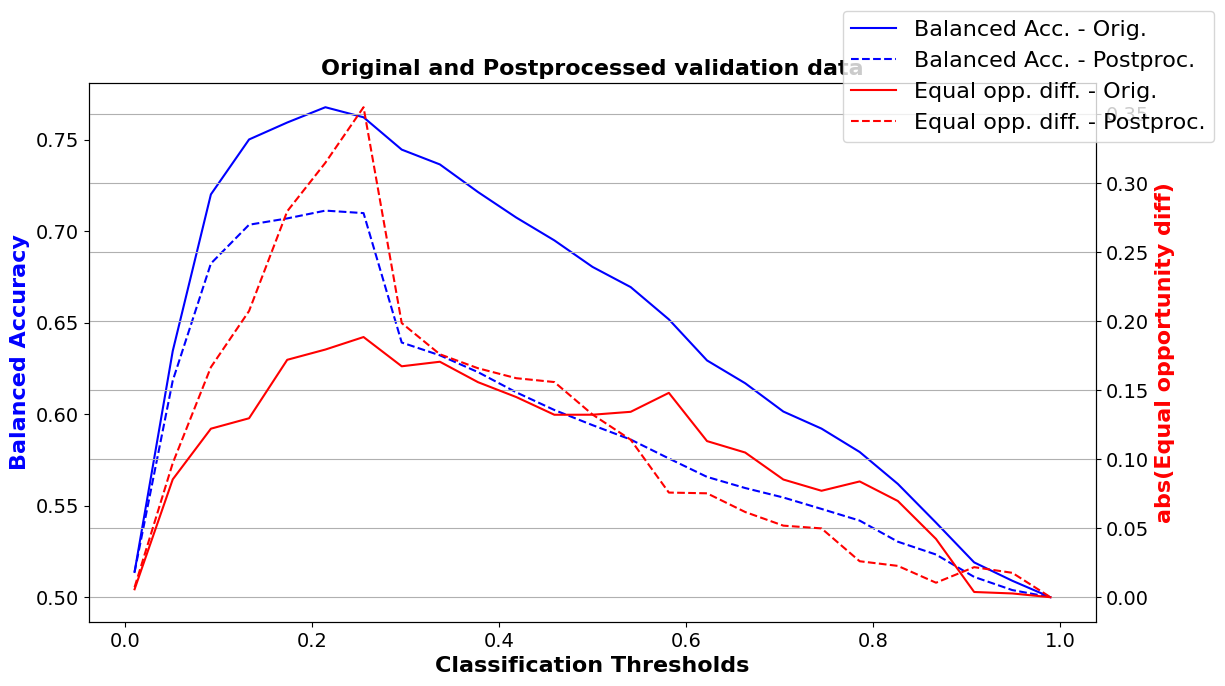

In [212]:
bef_bal_acc_valid = np.array(bef_bal_acc_valid)
bef_avg_odds_diff_valid = np.array(bef_avg_odds_diff_valid)

aft_bal_acc_valid = np.array(aft_bal_acc_valid)
aft_avg_odds_diff_valid = np.array(aft_avg_odds_diff_valid)

fig, ax1 = plt.subplots(figsize=(13,7))
ax1.plot(all_thresh, bef_bal_acc_valid, color='b')
ax1.plot(all_thresh, aft_bal_acc_valid, color='b', linestyle='dashed')
ax1.set_title('Original and Postprocessed validation data', fontsize=16, fontweight='bold')
ax1.set_xlabel('Classification Thresholds', fontsize=16, fontweight='bold')
ax1.set_ylabel('Balanced Accuracy', color='b', fontsize=16, fontweight='bold')
ax1.xaxis.set_tick_params(labelsize=14)
ax1.yaxis.set_tick_params(labelsize=14)

ax2 = ax1.twinx()
ax2.plot(all_thresh, np.abs(bef_avg_odds_diff_valid), color='r')
ax2.plot(all_thresh, np.abs(aft_avg_odds_diff_valid), color='r', linestyle='dashed')
ax2.set_ylabel('abs(Equal opportunity diff)', color='r', fontsize=16, fontweight='bold')
ax2.yaxis.set_tick_params(labelsize=14)
ax2.grid(True)
fig.legend(["Balanced Acc. - Orig.", "Balanced Acc. - Postproc.",
             "Equal opp. diff. - Orig.","Equal opp. diff. - Postproc.",], 
           fontsize=16)

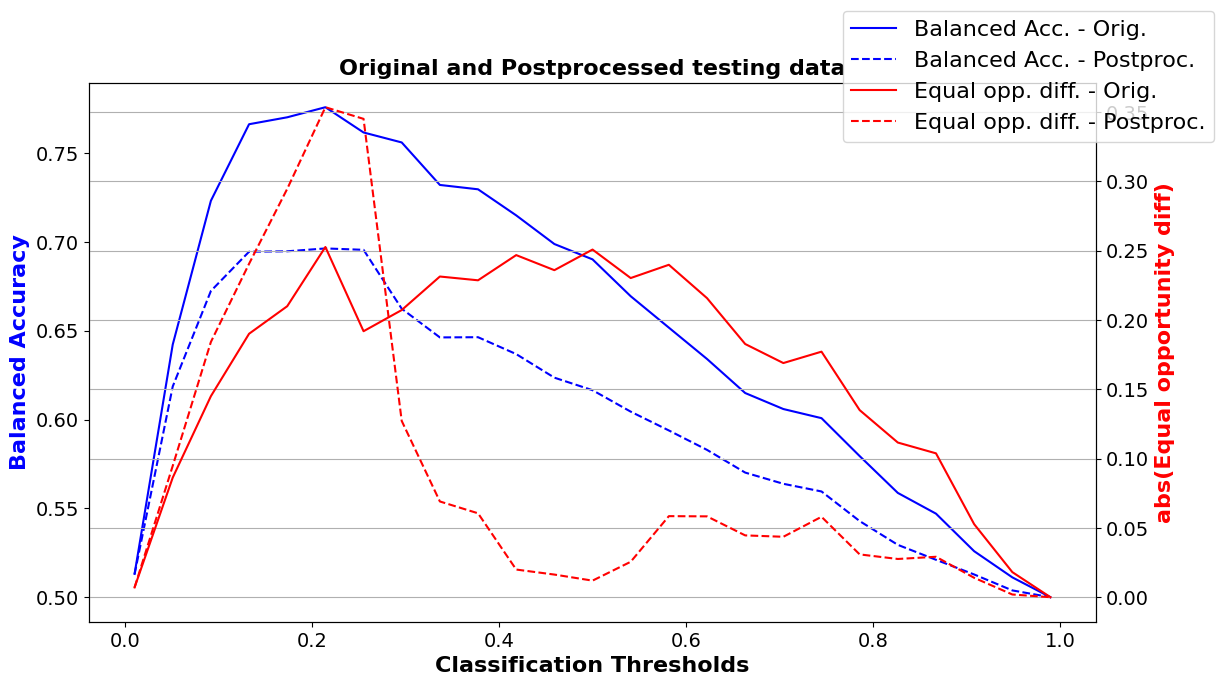

In [213]:
bef_bal_acc_test = np.array(bef_bal_acc_test)
bef_avg_odds_diff_test = np.array(bef_avg_odds_diff_test)

aft_bal_acc_test = np.array(aft_bal_acc_test)
aft_avg_odds_diff_test = np.array(aft_avg_odds_diff_test)

fig, ax1 = plt.subplots(figsize=(13,7))
ax1.plot(all_thresh, bef_bal_acc_test, color='b')
ax1.plot(all_thresh, aft_bal_acc_test, color='b', linestyle='dashed')
ax1.set_title('Original and Postprocessed testing data', fontsize=16, fontweight='bold')
ax1.set_xlabel('Classification Thresholds', fontsize=16, fontweight='bold')
ax1.set_ylabel('Balanced Accuracy', color='b', fontsize=16, fontweight='bold')
ax1.xaxis.set_tick_params(labelsize=14)
ax1.yaxis.set_tick_params(labelsize=14)


ax2 = ax1.twinx()
ax2.plot(all_thresh, np.abs(bef_avg_odds_diff_test), color='r')
ax2.plot(all_thresh, np.abs(aft_avg_odds_diff_test), color='r', linestyle='dashed')
ax2.set_ylabel('abs(Equal opportunity diff)', color='r', fontsize=16, fontweight='bold')
ax2.yaxis.set_tick_params(labelsize=14)
ax2.grid(True)
fig.legend(["Balanced Acc. - Orig.", "Balanced Acc. - Postproc.",
            "Equal opp. diff. - Orig.", "Equal opp. diff. - Postproc."], 
           fontsize=16)

## Section 5 Discussion

Use these questions to evaluate your models during bias-mitigation processes. 

### 5A. For **both** the logistic regression and random forest classifiers, please include visualizations the pre-processing results of your bias mitigation techniques. 

**In addition, for each Model + Bias mitigation technique, please write 1-2 SENTENCES explaining the following:**

1. Describe the bias mitigation techniques applied (what stage? type? explain what that debiasing technique does?) 
2. Based on defintions and sources of bias we covered in class, what type of bias are we trying to mitigate in our models?
3. Do both models exhibit fairness and maintain accuracy? List the fairness metrics you used to support this. What about model drift?
4. For the classifier ‘high’ utilization in these models + pre-processing mitigation technique; would you recommend this for our use case as a "fair" classifier? Why or why not? Use previous questions and the slide 'Sources of Bias in AI and Health Data' from our Week-07 slides, to help you answer this. 


### 5B. For **both** the logistic regression and random forest classifiers, please include visualizations the post-processing results of your bias mitigation techniques. 

**In addition, for each Model + Bias mitigation technique, please write 1-2 SENTENCES explaining the following:**

1. Describe the bias mitigation techniques applied (what stage? type? explain what that debiasing technique does?) 
2. Based on defintions and sources of bias we covered in class, what type of bias are we trying to mitigate in our models?
3. Do both models exhibit fairness and maintain accuracy? List the fairness metrics you used to support this. What about model drift?
4. For the classifier ‘high’ utilization in these models + post-processing mitigation technique; would you recommend this for our use case as a "fair" classifier? Why or why not? Use previous questions and the slide 'Sources of Bias in AI and Health Data' from our Week-07 slides, to help you answer this. 

### 5C. For **both** the logistic regression and random forest classifiers, please include visualizations for processing results of your bias mitigation techniques OF YOUR CHOICE. 

**In addition, for each Model + Bias mitigation technique of your choice, please write 1-2 SENTENCES explaining the following:**

1. Describe the bias mitigation techniques applied (what stage? type? explain what that debiasing technique does?) 
2. Based on defintions and sources of bias we covered in class, what type of bias are we trying to mitigate in our models?
3. Do both models exhibit fairness and maintain accuracy? List the fairness metrics you used to support this. What about model drift?
4. For the classifier ‘high’ utilization in these models + post-processing mitigation technique; would you recommend this for our use case as a "fair" classifier? Why or why not? Use previous questions and the slide 'Sources of Bias in AI and Health Data' from our Week-07 slides, to help you answer this.

## Section 5: Overall Discussion for Bias Mitigation, write 1-2 paragraphs for each question

1. What factors must be considered during AI model-development and performance? How and where are they vulnerable to introducing bias?
2. How and what should be measured to assess downstream impact of AI, and what factors should be used to audit for bias and clinical impact? 
3. Define what disparate impact is. How can the type, dimension, collection-method, and representation in data lead to bias and disparate impact in communities of concern? Use the MEPS codebooks, and websites to help you explain this. Refer to Center of Disease Control (CDC) [Health Equity Guiding Principles for Inclusive Communication](https://www.cdc.gov/healthcommunication/Health_Equity.html) for style recommendations when referring to affected groups. 
4. Where there any social factors overlooked when developing AI-targets or outcomes for the AIF360 exmaple? How could they delay access and quality of care to underserved populations?
5. (a) Overall, if you were to select ONE (a) Model, and (b) Bias-mitigation technique - for this use case where you are recommending a 'Fair' classifier for flagging 'High' utilization, which would you chose and why? (b) How would it affect Non-White beneficiaries who could have risk factor predictors that could inform a model to prioritize additional care? How could it do the opposite? (c) Explain how you would justify fair-accuracy trade-off. 

### [6.](#Table-of-Contents) Explainability

### [7.](#Table-of-Contents) Conclusion & Discussion